Import thư viện cần thiết

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import category_encoders as ce

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_curve, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import CategoricalNB, BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

import plotly.graph_objects as go
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("US_Accidents_filtered.csv")
df

ID   Source  Severity       Start_Time         End_Time  \
0        A-3765159  Source1         2    1/1/2022 0:02    1/1/2022 1:20   
1        A-4469836  Source1         2    1/1/2022 0:02    1/1/2022 3:26   
2        A-4440131  Source1         2    1/1/2022 0:05          24:06.0   
3         A-757745  Source2         3    1/1/2022 0:06    1/1/2022 0:35   
4        A-4431371  Source1         2    1/1/2022 0:06          31:30.0   
...            ...      ...       ...              ...              ...   
1048570  A-3663193  Source1         2  3/31/2023 23:18          36:30.0   
1048571  A-3687382  Source1         2  3/31/2023 23:19  3/31/2023 23:40   
1048572  A-3660237  Source1         2  3/31/2023 23:21  3/31/2023 23:38   
1048573  A-3678205  Source1         2  3/31/2023 23:25  3/31/2023 23:38   
1048574  A-3682074  Source1         2  3/31/2023 23:30  3/31/2023 23:53   

         Start_Lat   Start_Lng    End_Lat     End_Lng  Distance(mi)  ...  \
0        41.646392 -122.522389  41.647206 -122.522404         0.056  ...   
1        38.131316 -120.844638  38.132593 -120.840530         0.240  ...   
2        42.066768  -88.135017  42.066698  -88.153427         0.944  ...   
3        42.066635  -88.144135        NaN         NaN         0.000  ...   
4        28.439415  -81.471060  28.449853  -81.470863         0.721  ...   
...            ...         ...        ...         ...           ...  ...   
1048570  32.909061  -96.732217  32.903161  -96.722472         0.697  ...   
1048571  42.959427  -85.672227  42.957582  -85.671804         0.129  ...   
1048572  38.361154 -121.970167  38.356127 -121.976854         0.502  ...   
1048573  34.068219 -117.384067  34.068406 -117.375980         0.463  ...   
1048574  42.419172  -83.088509  42.431590  -83.094532         0.911  ...   

        Roundabout Station   Stop Traffic_Calming Traffic_Signal Turning_Loop  \
0            False   False  False           False          False        False   
1            False   False  False           False          False        False   
2            False   False  False           False          False        False   
3            False   False  False           False           True        False   
4            False    True  False           False          False        False   
...            ...     ...    ...             ...            ...          ...   
1048570      False   False  False           False          False        False   
1048571      False   False  False           False          False        False   
1048572      False   False  False           False          False        False   
1048573      False   False  False           False          False        False   
1048574      False   False  False           False          False        False   

        Sunrise_Sunset Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0                Night          Night             Night                 Night  
1                Night          Night             Night                 Night  
2                Night          Night             Night                 Night  
3                Night          Night             Night                 Night  
4                Night          Night             Night                 Night  
...                ...            ...               ...                   ...  
1048570          Night          Night             Night                 Night  
1048571          Night          Night             Night                 Night  
1048572          Night          Night             Night                 Night  
1048573          Night          Night             Night                 Night  
1048574          Night          Night             Night                 Night  

[1048575 rows x 46 columns]

# CALCULATE THE VALUES

In [3]:
numeric_cols = df.select_dtypes(include=['int', 'float']).columns
stats = df[numeric_cols].describe().T
for col in df[numeric_cols].columns:
    stats.loc[col, 'mode'] = df[col].mode()[0]
for col in df[numeric_cols].columns:
    stats.loc[col, 'range'] = df[col].max() - df[col].min()
for col in df[numeric_cols].columns:
    stats.loc[col, 'variance'] = df[col].var()
display(stats)

count       mean        std         min         25%  \
Severity           1048575.0   2.083738   0.441000    1.000000    2.000000   
Start_Lat          1048575.0  36.045071   5.070074   24.554800   33.291639   
Start_Lng          1048575.0 -93.570904  17.368333 -124.541015 -116.354635   
End_Lat             812393.0  36.077196   5.173824   24.570107   33.371521   
End_Lng             812393.0 -94.178039  17.797472 -124.539056 -117.273791   
Distance(mi)       1048575.0   0.844440   2.057665    0.000000    0.023000   
Temperature(F)     1025629.0  61.212504  19.889532  -38.000000   48.000000   
Wind_Chill(F)      1016788.0  59.760127  22.319197  -63.000000   46.000000   
Humidity(%)        1024029.0  63.189945  23.055233    1.000000   46.000000   
Pressure(in)       1028858.0  29.349853   1.147297   19.310000   29.170000   
Visibility(mi)     1023813.0   9.074352   2.466257    0.000000   10.000000   
Wind_Speed(mph)    1020279.0   7.658445   5.575694    0.000000    3.000000   
Precipitation(in)  1009729.0   0.005966   0.057178    0.000000    0.000000   

                         50%        75%         max       mode       range  \
Severity            2.000000   2.000000    4.000000   2.000000    3.000000   
Start_Lat          35.890030  40.003377   49.000504  25.823117   24.445704   
Start_Lng         -85.672461 -80.169301  -68.283783 -80.206386   56.257232   
End_Lat            36.115157  40.038087   49.002025  28.450015   24.431918   
End_Lng           -85.711581 -80.117239  -69.088179 -81.471375   55.450877   
Distance(mi)        0.190000   0.880000  336.570007   0.000000  336.570007   
Temperature(F)     64.000000  77.000000  207.000000  73.000000  245.000000   
Wind_Chill(F)      64.000000  77.000000  207.000000  73.000000  270.000000   
Humidity(%)        65.000000  83.000000  100.000000  93.000000   99.000000   
Pressure(in)       29.690000  29.960000   58.630000  29.970000   39.320000   
Visibility(mi)     10.000000  10.000000  100.000000  10.000000  100.000000   
Wind_Speed(mph)     7.000000  10.000000  190.000000   0.000000  190.000000   
Precipitation(in)   0.000000   0.000000   36.470000   0.000000   36.470000   

                     variance  
Severity             0.194481  
Start_Lat           25.705649  
Start_Lng          301.658981  
End_Lat             26.768460  
End_Lng            316.750020  
Distance(mi)         4.233986  
Temperature(F)     395.593501  
Wind_Chill(F)      498.146537  
Humidity(%)        531.543746  
Pressure(in)         1.316289  
Visibility(mi)       6.082426  
Wind_Speed(mph)     31.088364  
Precipitation(in)    0.003269

# 1. Exploratory Data Analysis (EDA)

# 1.1. Visualizing the number of accidents that occurred in each state

Trực quan hóa số vụ tai nạn xảy ra trong từng bang

In [4]:
state_counts = df["State"].value_counts()
fig = go.Figure(data=go.Choropleth(locations=state_counts.index, z=state_counts.values.astype(float), locationmode="USA-states", colorscale="turbo"))
fig.update_layout(title_text="Number of US Accidents for each State", geo_scope="usa")
fig.show()

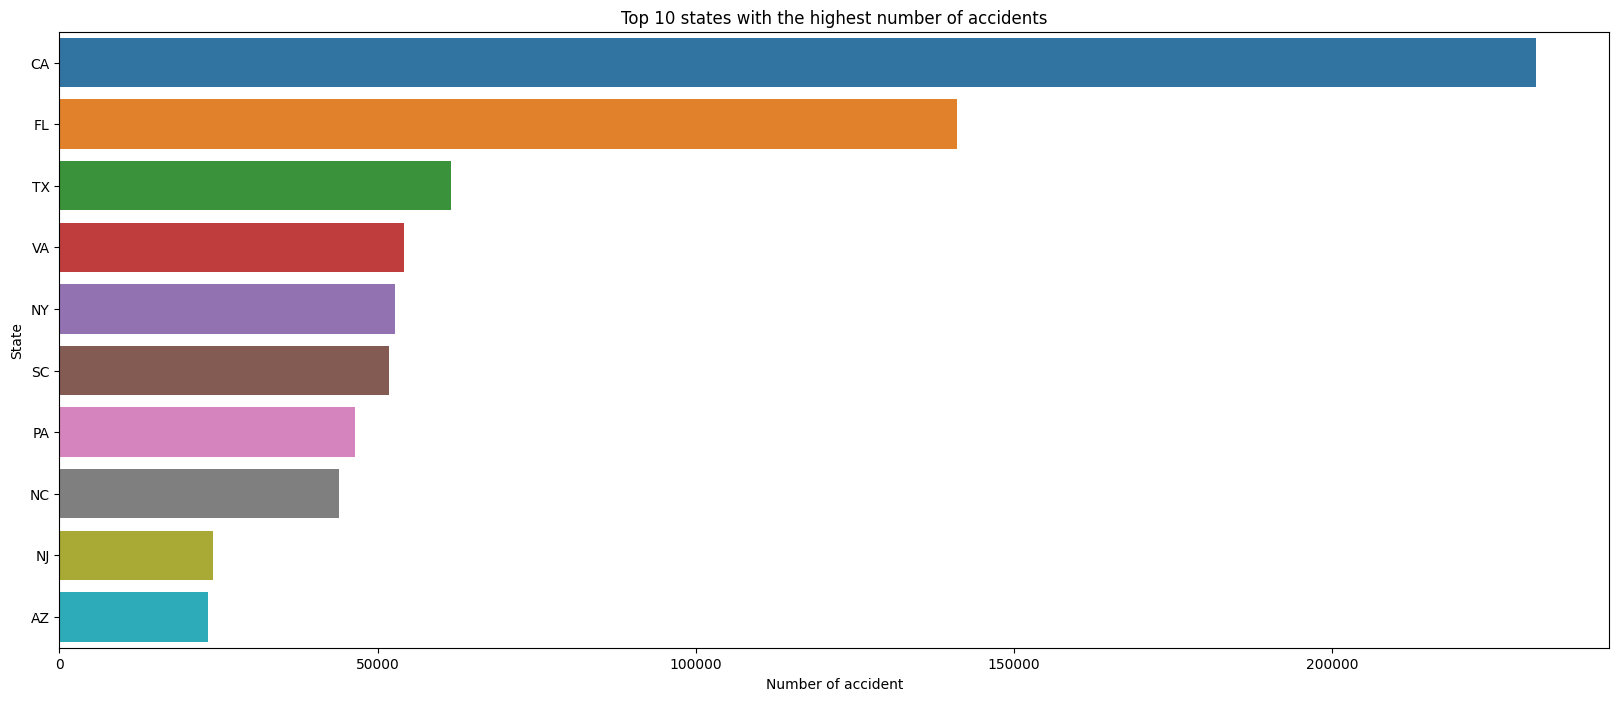

In [5]:
plt.figure(figsize=(20, 8))
plt.title("Top 10 states with the highest number of accidents")
sns.barplot(x = state_counts[:10].values, y = state_counts[:10].index, orient="h")
plt.xlabel("Number of accident")
plt.ylabel("State")
plt.show()

# 1.2. Most frequent words in the description of an accident with severity 4

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20520\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

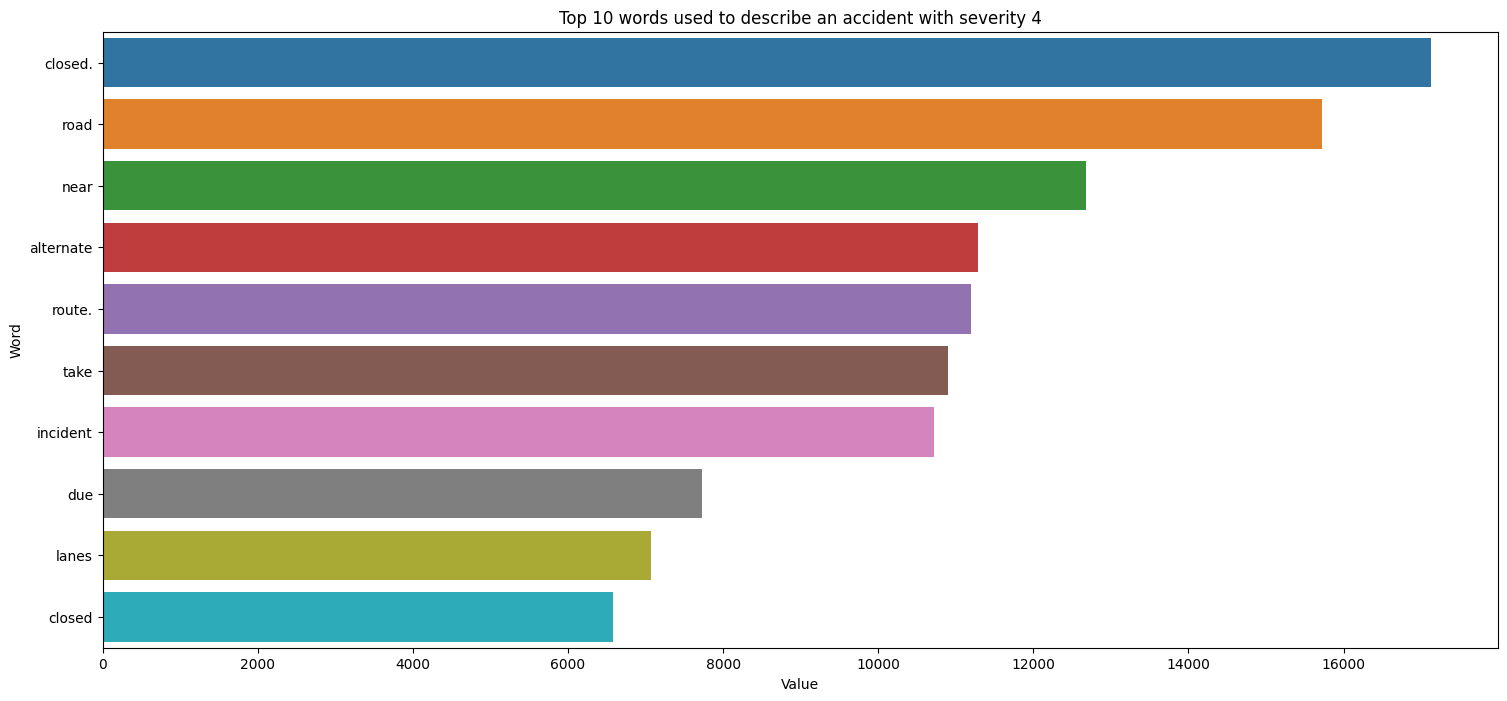

In [7]:
stop = stopwords.words("english") + ["-"]

df_s4_desc = df[df["Severity"] == 4]["Description"]
# Split the description
df_words = df_s4_desc.str.lower().str.split(expand=True).stack()

# If the word is not in the stopwords list
counts = df_words[~df_words.isin(stop)].value_counts()[:10]

plt.figure(figsize=(18, 8))
plt.title("Top 10 words used to describe an accident with severity 4")
sns.barplot(x = counts.values, y = counts.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Word")
plt.show()

# 1.3. Analyze which are the most frequent road features in accidents
### Phân tích đặc tính nào của đường xảy ra tai nạn nhiều nhất
Extract columns related to road features in the dataset. See which road feature is the most frequent location of accidents.

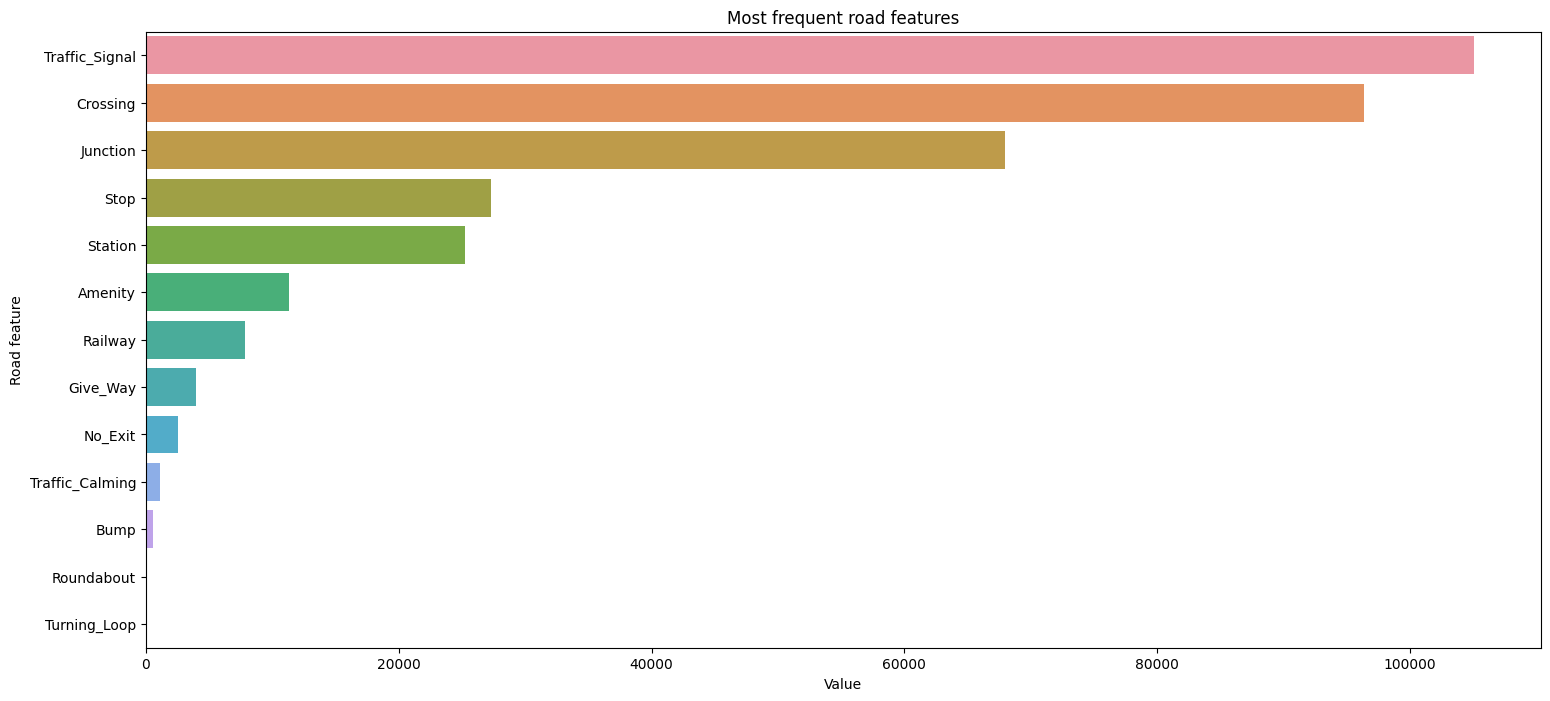

In [8]:
road_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
data = df[road_features].sum().sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Most frequent road features")
sns.barplot(x = data.values, y = data.index, orient="h")
plt.xlabel("Value")
plt.ylabel("Road feature")
plt.show()

# 1.4. Calculate mean distance group by Serverity
Tính trung bình quãng đường xảy ra tai nạn (đơn vị dặm) theo từng mức độ tai nạn

Calculate the mean distance of accidents for each level of severity.

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\834773398.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



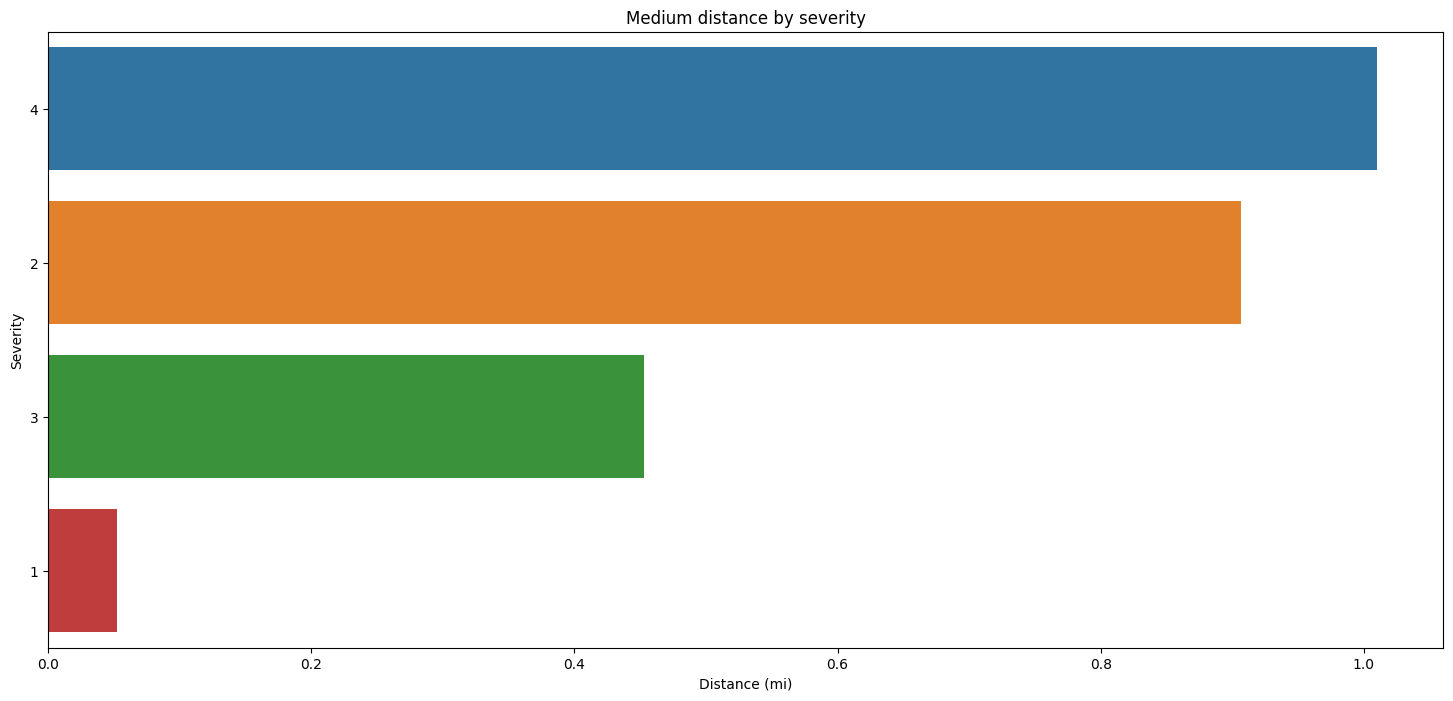

In [9]:
severity_distance = df.groupby("Severity").mean()["Distance(mi)"].sort_values(ascending=False)

plt.figure(figsize=(18, 8))
plt.title("Medium distance by severity")
sns.barplot(x = severity_distance.values, y =severity_distance.index, orient="h", order=severity_distance.index)
plt.xlabel("Distance (mi)")
plt.show()

# 1.5. Analyze weather condition

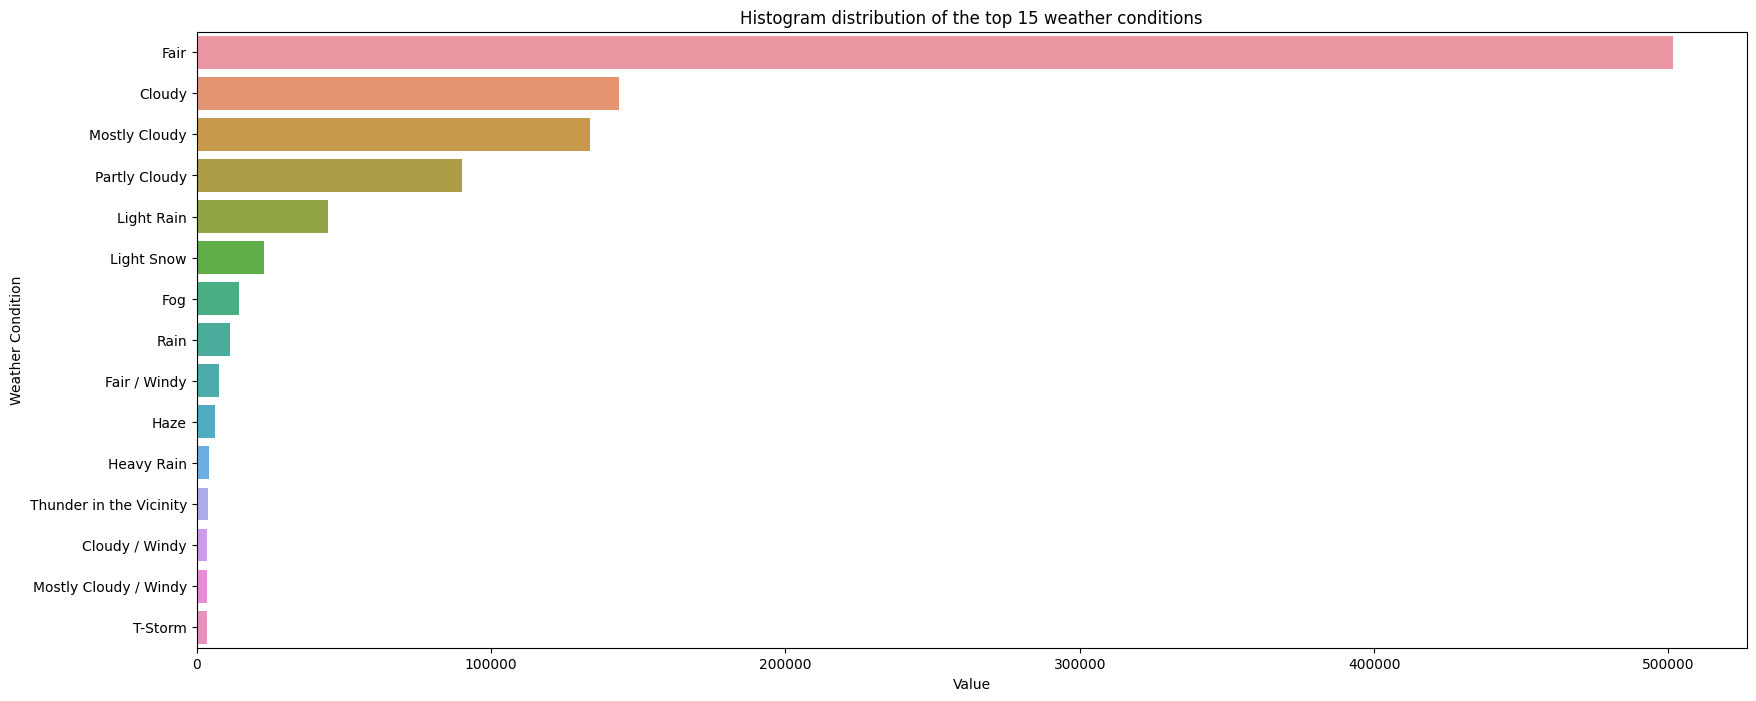

In [10]:
counts = df["Weather_Condition"].value_counts()[:15]
plt.figure(figsize=(20, 8))
plt.title("Histogram distribution of the top 15 weather conditions")
sns.barplot(x = counts.values, y = counts.index)
plt.xlabel("Value")
plt.ylabel("Weather Condition")
plt.show()

# 1.6. Analyze number of accidents appened in each weekday

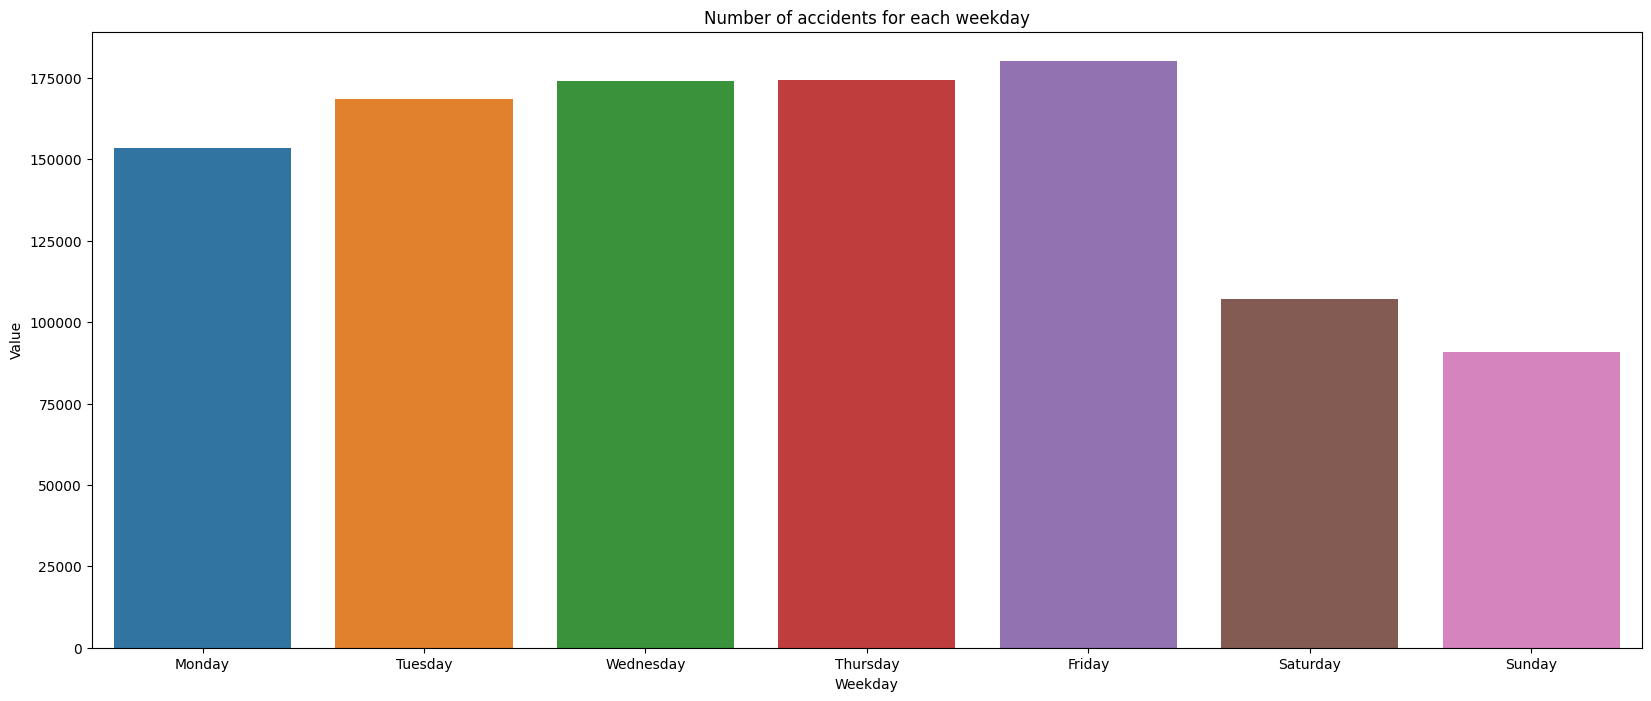

In [11]:
counts = pd.to_datetime(df['Start_Time']).dt.day_name().value_counts()
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

plt.figure(figsize=(20, 8))
plt.title("Number of accidents for each weekday")
sns.barplot(x = counts.index, y =counts.values, order=weekdays)
plt.xlabel("Weekday")
plt.ylabel("Value")
plt.show()

Our project aims to predict the severity of accidents in the United States by analyzing a range of features that have been recorded in this dataset. The goal is to provide insights into what factors contribute to the severity of accidents, and to identify potential high-risk areas or situations.

# 2. Data preprocessing

In [12]:
X = df
X.head()

ID   Source  Severity     Start_Time       End_Time  Start_Lat  \
0  A-3765159  Source1         2  1/1/2022 0:02  1/1/2022 1:20  41.646392   
1  A-4469836  Source1         2  1/1/2022 0:02  1/1/2022 3:26  38.131316   
2  A-4440131  Source1         2  1/1/2022 0:05        24:06.0  42.066768   
3   A-757745  Source2         3  1/1/2022 0:06  1/1/2022 0:35  42.066635   
4  A-4431371  Source1         2  1/1/2022 0:06        31:30.0  28.439415   

    Start_Lng    End_Lat     End_Lng  Distance(mi)  ... Roundabout Station  \
0 -122.522389  41.647206 -122.522404         0.056  ...      False   False   
1 -120.844638  38.132593 -120.840530         0.240  ...      False   False   
2  -88.135017  42.066698  -88.153427         0.944  ...      False   False   
3  -88.144135        NaN         NaN         0.000  ...      False   False   
4  -81.471060  28.449853  -81.470863         0.721  ...      False    True   

    Stop Traffic_Calming Traffic_Signal Turning_Loop Sunrise_Sunset  \
0  False           False          False        False          Night   
1  False           False          False        False          Night   
2  False           False          False        False          Night   
3  False           False           True        False          Night   
4  False           False          False        False          Night   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight  
0          Night             Night                 Night  
1          Night             Night                 Night  
2          Night             Night                 Night  
3          Night             Night                 Night  
4          Night             Night                 Night  

[5 rows x 46 columns]

# 2.1. Feature addition

In [13]:
X["Start_Time"] = pd.to_datetime(X["Start_Time"])

# Extract year, month, weekday and day
X["Year"] = X["Start_Time"].dt.year
X["Month"] = X["Start_Time"].dt.month
X["Weekday"] = X["Start_Time"].dt.weekday
X["Day"] = X["Start_Time"].dt.day

# Extract hour and minute
X["Hour"] = X["Start_Time"].dt.hour
X["Minute"] = X["Start_Time"].dt.minute

X.head()

ID   Source  Severity          Start_Time       End_Time  Start_Lat  \
0  A-3765159  Source1         2 2022-01-01 00:02:00  1/1/2022 1:20  41.646392   
1  A-4469836  Source1         2 2022-01-01 00:02:00  1/1/2022 3:26  38.131316   
2  A-4440131  Source1         2 2022-01-01 00:05:00        24:06.0  42.066768   
3   A-757745  Source2         3 2022-01-01 00:06:00  1/1/2022 0:35  42.066635   
4  A-4431371  Source1         2 2022-01-01 00:06:00        31:30.0  28.439415   

    Start_Lng    End_Lat     End_Lng  Distance(mi)  ... Sunrise_Sunset  \
0 -122.522389  41.647206 -122.522404         0.056  ...          Night   
1 -120.844638  38.132593 -120.840530         0.240  ...          Night   
2  -88.135017  42.066698  -88.153427         0.944  ...          Night   
3  -88.144135        NaN         NaN         0.000  ...          Night   
4  -81.471060  28.449853  -81.470863         0.721  ...          Night   

  Civil_Twilight Nautical_Twilight Astronomical_Twilight  Year Month Weekday  \
0          Night             Night                 Night  2022     1       5   
1          Night             Night                 Night  2022     1       5   
2          Night             Night                 Night  2022     1       5   
3          Night             Night                 Night  2022     1       5   
4          Night             Night                 Night  2022     1       5   

  Day Hour Minute  
0   1    0      2  
1   1    0      2  
2   1    0      5  
3   1    0      6  
4   1    0      6  

[5 rows x 52 columns]

# 2.2. Check correlation between features 

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\2750478310.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



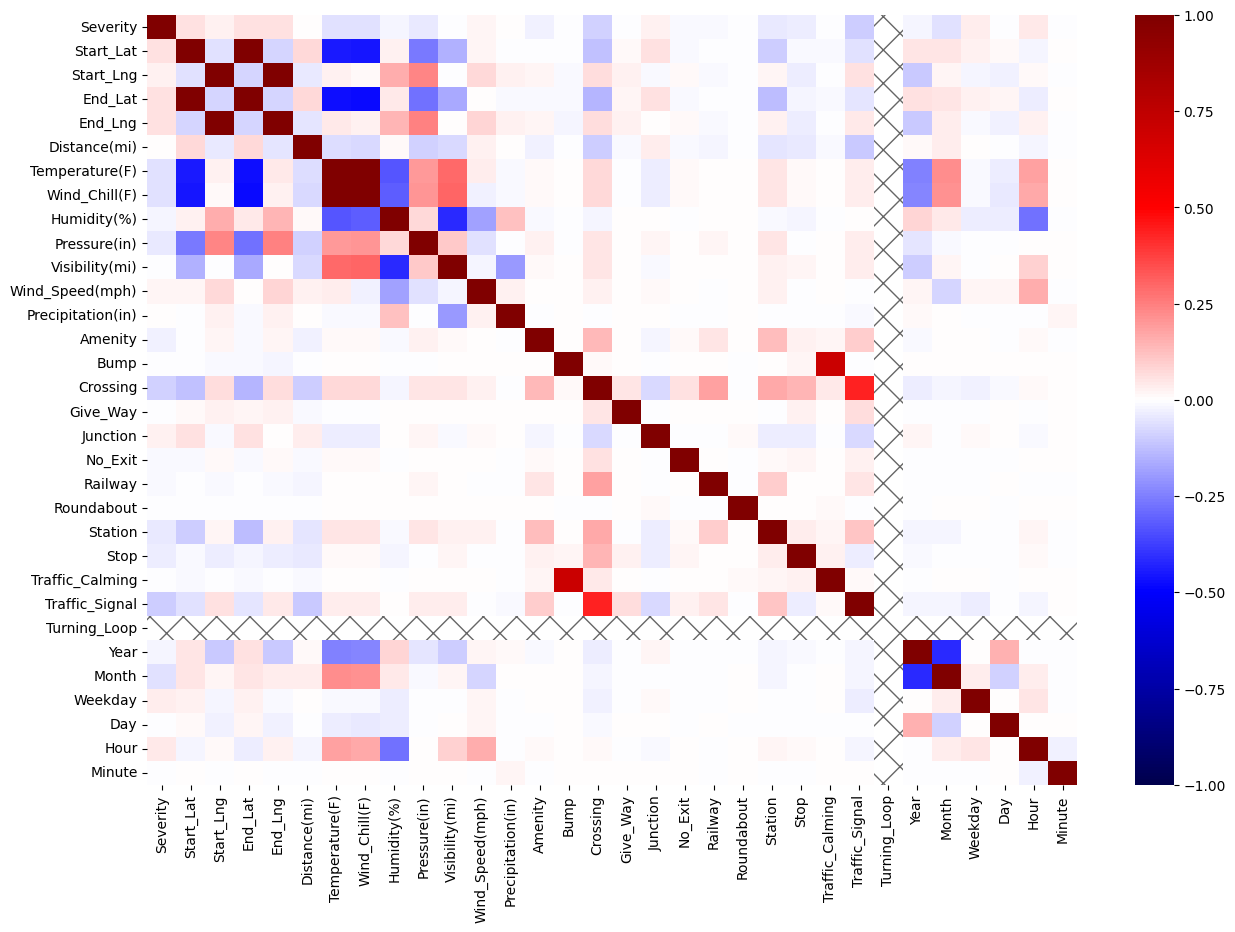

In [14]:
corr_matrix = X.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap="seismic")
plt.gca().patch.set(hatch="X", edgecolor="#666")
plt.show()

# 2.3 Feature selection

In [15]:
features_to_drop = ["ID", "Source", "Start_Time", "End_Time", "End_Lat", "End_Lng", "Description", "Street", "County", "State", "Zipcode", "Country", "Timezone", "Airport_Code", "Weather_Timestamp", "Wind_Chill(F)", "Turning_Loop", "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]
X = X.drop(features_to_drop, axis=1)
X.head()

Severity  Start_Lat   Start_Lng  Distance(mi)             City  \
0         2  41.646392 -122.522389         0.056          Grenada   
1         2  38.131316 -120.844638         0.240   Valley Springs   
2         2  42.066768  -88.135017         0.944  Hoffman Estates   
3         3  42.066635  -88.144135         0.000  Hoffman Estates   
4         2  28.439415  -81.471060         0.721          Orlando   

   Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi) Wind_Direction  \
0            24.0         84.0         27.31            10.0            WSW   
1            28.0        100.0         27.74            10.0           CALM   
2            34.0         92.0         28.91             2.0              N   
3            34.0         92.0         28.91             2.0              N   
4            72.0         87.0         29.98             2.0              S   

   ...   Stop  Traffic_Calming Traffic_Signal  Civil_Twilight  Year  Month  \
0  ...  False            False          False           Night  2022      1   
1  ...  False            False          False           Night  2022      1   
2  ...  False            False          False           Night  2022      1   
3  ...  False            False           True           Night  2022      1   
4  ...  False            False          False           Night  2022      1   

   Weekday  Day  Hour  Minute  
0        5    1     0       2  
1        5    1     0       2  
2        5    1     0       5  
3        5    1     0       6  
4        5    1     0       6  

[5 rows x 32 columns]

# 2.4. Drop duplicates

In [16]:
print("Number of rows:", len(X.index))
X.drop_duplicates(inplace=True)
print("Number of rows after drop of duplicates:", len(X.index))

Number of rows: 1048575
Number of rows after drop of duplicates: 1007110


# 2.5 Handle erroneous and missing values

In [17]:
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

Pressure(in)  Visibility(mi)
count     988086.00       983223.00
mean          29.35            9.07
std            1.15            2.47
min           19.31            0.00
25%           29.17           10.00
50%           29.69           10.00
75%           29.96           10.00
max           58.63          100.00

In [18]:
X = X[X["Pressure(in)"] != 0]
X = X[X["Visibility(mi)"] != 0]
X[["Pressure(in)", "Visibility(mi)"]].describe().round(2)

Pressure(in)  Visibility(mi)
count     986592.00       981721.00
mean          29.35            9.09
std            1.14            2.44
min           19.31            0.06
25%           29.17           10.00
50%           29.69           10.00
75%           29.96           10.00
max           58.63          100.00

In [19]:
unique_weather = X["Weather_Condition"].unique()

print(len(unique_weather))
print(unique_weather)

96
['Fair' 'Fog' 'Mist' 'Cloudy' 'Light Snow' nan 'Mostly Cloudy' 'Haze'
 'Partly Cloudy' 'Light Rain' 'Light Snow / Windy' 'Wintry Mix'
 'Heavy Snow' 'Rain' 'Light Drizzle' 'Wintry Mix / Windy'
 'N/A Precipitation' 'Partly Cloudy / Windy' 'Snow' 'Snow / Windy'
 'Fair / Windy' 'Mostly Cloudy / Windy' 'Cloudy / Windy' 'T-Storm'
 'Heavy Rain' 'Heavy Rain / Windy' 'Fog / Windy' 'Heavy T-Storm'
 'Heavy Drizzle' 'Light Drizzle / Windy' 'Drizzle' 'Patches of Fog'
 'Light Rain / Windy' 'Light Rain with Thunder' 'Squalls' 'Rain / Windy'
 'Thunder in the Vicinity' 'Haze / Windy' 'T-Storm / Windy'
 'Heavy Snow / Windy' 'Light Snow and Sleet' 'Snow and Sleet'
 'Blowing Snow' 'Snow and Sleet / Windy' 'Light Freezing Rain'
 'Blowing Snow / Windy' 'Shallow Fog' 'Light Freezing Drizzle'
 'Freezing Rain' 'Smoke' 'Thunder' 'Light Freezing Rain / Windy'
 'Showers in the Vicinity' 'Sleet' 'Heavy Sleet' 'Heavy T-Storm / Windy'
 'Freezing Rain / Windy' 'Light Sleet / Windy' 'Light Sleet'
 'Blowing Dust' 'W

In [20]:
X.loc[X["Weather_Condition"].str.contains("Thunder|T-Storm", na=False), "Weather_Condition"] = "Thunderstorm"
X.loc[X["Weather_Condition"].str.contains("Snow|Sleet|Wintry", na=False), "Weather_Condition"] = "Snow"
X.loc[X["Weather_Condition"].str.contains("Rain|Drizzle|Shower", na=False), "Weather_Condition"] = "Rain"
X.loc[X["Weather_Condition"].str.contains("Wind|Squalls", na=False), "Weather_Condition"] = "Windy"
X.loc[X["Weather_Condition"].str.contains("Hail|Pellets", na=False), "Weather_Condition"] = "Hail"
X.loc[X["Weather_Condition"].str.contains("Fair", na=False), "Weather_Condition"] = "Clear"
X.loc[X["Weather_Condition"].str.contains("Cloud|Overcast", na=False), "Weather_Condition"] = "Cloudy"
X.loc[X["Weather_Condition"].str.contains("Mist|Haze|Fog", na=False), "Weather_Condition"] = "Fog"
X.loc[X["Weather_Condition"].str.contains("Sand|Dust", na=False), "Weather_Condition"] = "Sand"
X.loc[X["Weather_Condition"].str.contains("Smoke|Volcanic Ash", na=False), "Weather_Condition"] = "Smoke"
X.loc[X["Weather_Condition"].str.contains("N/A Precipitation", na=False), "Weather_Condition"] = np.nan

print(X["Weather_Condition"].unique())

['Clear' 'Fog' 'Cloudy' 'Snow' nan 'Rain' 'Windy' 'Thunderstorm' 'Smoke'
 'Sand' 'Hail' 'Tornado']


In [21]:
X["Wind_Direction"].unique()

array(['WSW', 'CALM', 'N', 'S', 'WNW', 'NW', 'NNE', 'NE', nan, 'ESE',
       'ENE', 'SW', 'W', 'SSW', 'E', 'VAR', 'NNW', 'SSE', 'SE'],
      dtype=object)

In [22]:
X.loc[X["Wind_Direction"] == "CALM", "Wind_Direction"] = "Calm"
X.loc[X["Wind_Direction"] == "VAR", "Wind_Direction"] = "Variable"
X.loc[X["Wind_Direction"] == "East", "Wind_Direction"] = "E"
X.loc[X["Wind_Direction"] == "North", "Wind_Direction"] = "N"
X.loc[X["Wind_Direction"] == "South", "Wind_Direction"] = "S"
X.loc[X["Wind_Direction"] == "West", "Wind_Direction"] = "W"

X["Wind_Direction"] = X["Wind_Direction"].map(lambda x : x if len(x) != 3 else x[1:], na_action="ignore")

X["Wind_Direction"].unique()

array(['SW', 'Calm', 'N', 'S', 'NW', 'NE', nan, 'SE', 'W', 'E',
       'Variable'], dtype=object)

In [23]:
X.isna().sum()


Severity                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
City                    34
Temperature(F)       22123
Humidity(%)          23635
Pressure(in)         19016
Visibility(mi)       23887
Wind_Direction       27209
Wind_Speed(mph)      27206
Precipitation(in)    37517
Weather_Condition    22931
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
Civil_Twilight        8050
Year                     0
Month                    0
Weekday                  0
Day                      0
Hour                     0
Minute                   0
dtype: int64

In [24]:
features_to_fill = ["Temperature(F)", "Humidity(%)", "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
X[features_to_fill] = X[features_to_fill].fillna(X[features_to_fill].mean())

X.dropna(inplace=True)

X.isna().sum()

Severity             0
Start_Lat            0
Start_Lng            0
Distance(mi)         0
City                 0
Temperature(F)       0
Humidity(%)          0
Pressure(in)         0
Visibility(mi)       0
Wind_Direction       0
Wind_Speed(mph)      0
Precipitation(in)    0
Weather_Condition    0
Amenity              0
Bump                 0
Crossing             0
Give_Way             0
Junction             0
No_Exit              0
Railway              0
Roundabout           0
Station              0
Stop                 0
Traffic_Calming      0
Traffic_Signal       0
Civil_Twilight       0
Year                 0
Month                0
Weekday              0
Day                  0
Hour                 0
Minute               0
dtype: int64

# 2.6. Check features variance

In [25]:
X.describe().round(2)


Severity  Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  \
count  968087.00  968087.00  968087.00     968087.00       968087.00   
mean        2.08      36.06     -93.66          0.84           61.20   
std         0.45       5.04      17.35          2.05           19.79   
min         1.00      24.55    -124.54          0.00          -38.00   
25%         2.00      33.33    -117.07          0.02           48.00   
50%         2.00      35.84     -85.96          0.19           64.00   
75%         2.00      40.00     -80.19          0.88           76.00   
max         4.00      49.00     -68.28        336.57          207.00   

       Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
count    968087.00     968087.00       968087.00        968087.00   
mean         63.26         29.35            9.09             7.62   
std          22.96          1.13            2.43             5.55   
min           1.00         19.31            0.06             0.00   
25%          46.00         29.17           10.00             3.00   
50%          65.00         29.69           10.00             7.00   
75%          83.00         29.96           10.00            10.00   
max         100.00         58.63          100.00           190.00   

       Precipitation(in)       Year      Month    Weekday        Day  \
count          968087.00  968087.00  968087.00  968087.00  968087.00   
mean                0.01    2022.12       5.60       2.71      15.62   
std                 0.06       0.33       3.54       1.84       8.63   
min                 0.00    2022.00       1.00       0.00       1.00   
25%                 0.00    2022.00       2.00       1.00       8.00   
50%                 0.00    2022.00       5.00       3.00      16.00   
75%                 0.00    2022.00       8.00       4.00      23.00   
max                36.47    2023.00      12.00       6.00      31.00   

            Hour     Minute  
count  968087.00  968087.00  
mean       12.46      29.56  
std         5.40      17.23  
min         0.00       0.00  
25%         8.00      15.00  
50%        13.00      30.00  
75%        17.00      44.00  
max        23.00      59.00

# 2.7. Handle unbalanced data

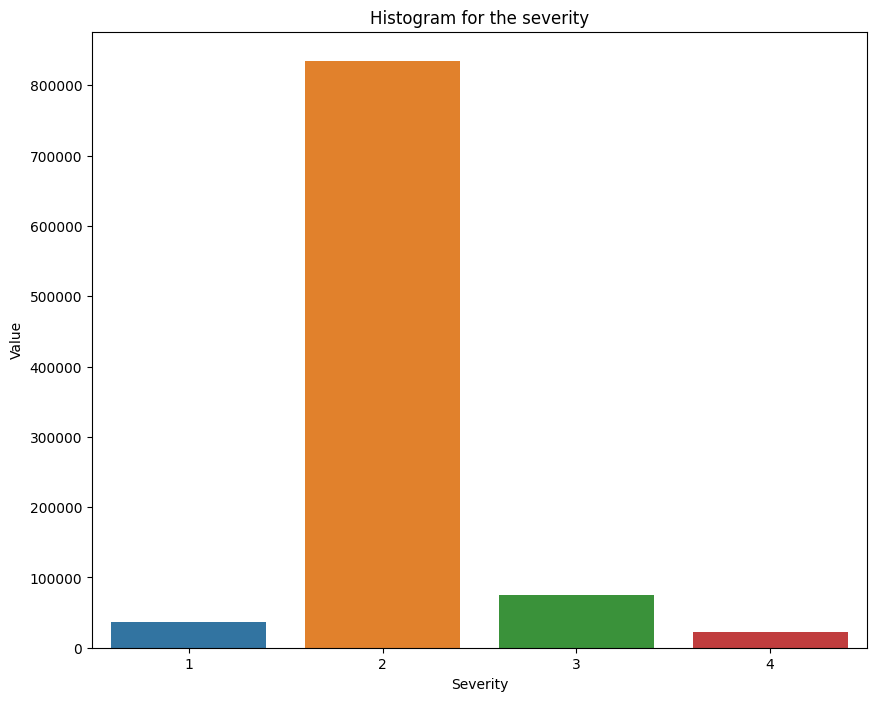

In [26]:
severity_counts = X["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x = severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [27]:
size = len(X[X["Severity"]==4].index)
df = pd.DataFrame()
for i in range(1,5):
    S = X[X["Severity"]==i]
    df = df.append(S.sample(size, random_state=42))
X = df

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\3400358108.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\3400358108.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\3400358108.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\3400358108.py:5: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



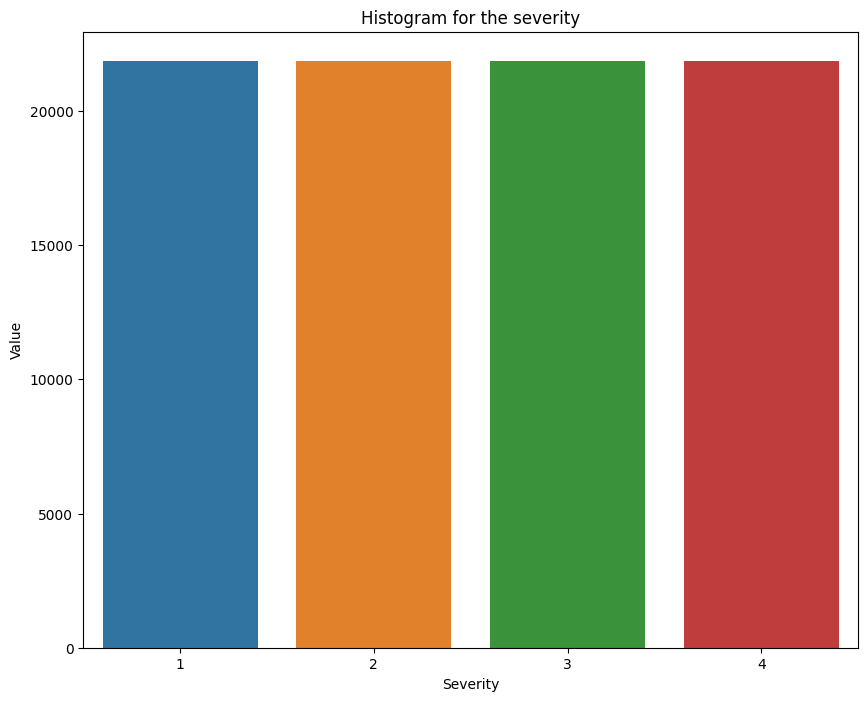

In [28]:
severity_counts = X["Severity"].value_counts()
plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x =severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

# 2.8. Feature scaling

In [29]:
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)',
'Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)','Start_Lng',
'Start_Lat','Year', 'Month','Weekday','Day','Hour','Minute']
X[features] = scaler.fit_transform(X[features])
X.head()

Severity  Start_Lat  Start_Lng  Distance(mi)         City  \
393210         1   0.403049   0.748964           0.0   Honea Path   
674695         1   0.506296   0.044177           0.0   Santa Cruz   
449409         1   0.424741   0.756341           0.0  Spartanburg   
667028         1   0.417148   0.745475           0.0       Easley   
489881         1   0.620151   0.717849           0.0    Kettering   

        Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
393210        0.608040     0.418367      0.496277        0.131944   
674695        0.447236     1.000000      0.532979        0.118590   
449409        0.582915     0.459184      0.503723        0.131944   
667028        0.628141     0.540816      0.492021        0.131944   
489881        0.618090     0.540816      0.498404        0.131944   

       Wind_Direction  ...   Stop  Traffic_Calming Traffic_Signal  \
393210             SW  ...  False            False           True   
674695             SW  ...  False            False          False   
449409           Calm  ...  False            False          False   
667028             SW  ...  False            False          False   
489881             SE  ...  False            False           True   

        Civil_Twilight  Year     Month   Weekday       Day      Hour    Minute  
393210             Day   0.0  0.363636  0.000000  0.500000  0.826087  0.118644  
674695           Night   0.0  0.727273  0.666667  0.033333  0.000000  0.711864  
449409             Day   0.0  0.454545  0.000000  0.166667  0.826087  0.847458  
667028             Day   0.0  0.636364  0.166667  0.966667  0.695652  0.525424  
489881             Day   0.0  0.454545  0.333333  0.700000  0.695652  0.830508  

[5 rows x 32 columns]

# 2.9. Feature encoding

In [30]:
categorical_features = set(["City", "Wind_Direction", "Weather_Condition", "Civil_Twilight"])

for cat in categorical_features:
    X[cat] = X[cat].astype("category")

X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87436 entries, 393210 to 813392
Data columns (total 32 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Severity           87436 non-null  int64   
 1   Start_Lat          87436 non-null  float64 
 2   Start_Lng          87436 non-null  float64 
 3   Distance(mi)       87436 non-null  float64 
 4   City               87436 non-null  category
 5   Temperature(F)     87436 non-null  float64 
 6   Humidity(%)        87436 non-null  float64 
 7   Pressure(in)       87436 non-null  float64 
 8   Visibility(mi)     87436 non-null  float64 
 9   Wind_Direction     87436 non-null  category
 10  Wind_Speed(mph)    87436 non-null  float64 
 11  Precipitation(in)  87436 non-null  float64 
 12  Weather_Condition  87436 non-null  category
 13  Amenity            87436 non-null  bool    
 14  Bump               87436 non-null  bool    
 15  Crossing           87436 non-null  bool    
 16

In [31]:
print("Unique classes for each categorical feature:")
for cat in categorical_features:
    print("{:15s}".format(cat), "\t", len(X[cat].unique()))

Unique classes for each categorical feature:
Weather_Condition 	 11
Wind_Direction  	 10
Civil_Twilight  	 2
City            	 6465


In [32]:
X = X.replace([True, False], [1, 0])

X.head()

Severity  Start_Lat  Start_Lng  Distance(mi)         City  \
393210         1   0.403049   0.748964           0.0   Honea Path   
674695         1   0.506296   0.044177           0.0   Santa Cruz   
449409         1   0.424741   0.756341           0.0  Spartanburg   
667028         1   0.417148   0.745475           0.0       Easley   
489881         1   0.620151   0.717849           0.0    Kettering   

        Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
393210        0.608040     0.418367      0.496277        0.131944   
674695        0.447236     1.000000      0.532979        0.118590   
449409        0.582915     0.459184      0.503723        0.131944   
667028        0.628141     0.540816      0.492021        0.131944   
489881        0.618090     0.540816      0.498404        0.131944   

       Wind_Direction  ...  Stop  Traffic_Calming Traffic_Signal  \
393210             SW  ...     0                0              1   
674695             SW  ...     0                0              0   
449409           Calm  ...     0                0              0   
667028             SW  ...     0                0              0   
489881             SE  ...     0                0              1   

        Civil_Twilight  Year     Month   Weekday       Day      Hour    Minute  
393210             Day   0.0  0.363636  0.000000  0.500000  0.826087  0.118644  
674695           Night   0.0  0.727273  0.666667  0.033333  0.000000  0.711864  
449409             Day   0.0  0.454545  0.000000  0.166667  0.826087  0.847458  
667028             Day   0.0  0.636364  0.166667  0.966667  0.695652  0.525424  
489881             Day   0.0  0.454545  0.333333  0.700000  0.695652  0.830508  

[5 rows x 32 columns]

In [33]:
onehot_cols = categorical_features - set(["City"])

X = pd.get_dummies(X, columns=onehot_cols, drop_first=True)

X.head()

C:\Users\20520\AppData\Local\Temp\ipykernel_8636\367874396.py:3: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



Severity  Start_Lat  Start_Lng  Distance(mi)         City  \
393210         1   0.403049   0.748964           0.0   Honea Path   
674695         1   0.506296   0.044177           0.0   Santa Cruz   
449409         1   0.424741   0.756341           0.0  Spartanburg   
667028         1   0.417148   0.745475           0.0       Easley   
489881         1   0.620151   0.717849           0.0    Kettering   

        Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  \
393210        0.608040     0.418367      0.496277        0.131944   
674695        0.447236     1.000000      0.532979        0.118590   
449409        0.582915     0.459184      0.503723        0.131944   
667028        0.628141     0.540816      0.492021        0.131944   
489881        0.618090     0.540816      0.498404        0.131944   

        Wind_Speed(mph)  ...  Weather_Condition_Fog  Weather_Condition_Hail  \
393210         0.075758  ...                      0                       0   
674695         0.022727  ...                      0                       0   
449409         0.000000  ...                      0                       0   
667028         0.098485  ...                      0                       0   
489881         0.113636  ...                      0                       0   

        Weather_Condition_Rain  Weather_Condition_Sand  \
393210                       0                       0   
674695                       0                       0   
449409                       0                       0   
667028                       0                       0   
489881                       0                       0   

        Weather_Condition_Smoke  Weather_Condition_Snow  \
393210                        0                       0   
674695                        0                       0   
449409                        0                       0   
667028                        0                       0   
489881                        0                       0   

        Weather_Condition_Thunderstorm  Weather_Condition_Tornado  \
393210                               0                          0   
674695                               0                          0   
449409                               0                          0   
667028                               0                          0   
489881                               0                          0   

        Weather_Condition_Windy  Civil_Twilight_Night  
393210                        0                     0  
674695                        0                     1  
449409                        0                     0  
667028                        0                     0  
489881                        0                     0  

[5 rows x 49 columns]

In [34]:
binary_encoder = ce.binary.BinaryEncoder()

city_binary_enc = binary_encoder.fit_transform(X["City"])
city_binary_enc

City_0  City_1  City_2  City_3  City_4  City_5  City_6  City_7  \
393210        0       0       0       0       0       0       0       0   
674695        0       0       0       0       0       0       0       0   
449409        0       0       0       0       0       0       0       0   
667028        0       0       0       0       0       0       0       0   
489881        0       0       0       0       0       0       0       0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
658959        1       0       1       0       1       1       0       0   
1038032       0       0       1       0       0       0       1       0   
332720        0       1       1       0       0       0       0       1   
45562         1       0       1       0       0       1       0       1   
813392        0       0       0       1       1       1       0       0   

         City_8  City_9  City_10  City_11  City_12  
393210        0       0        0        0        1  
674695        0       0        0        1        0  
449409        0       0        0        1        1  
667028        0       0        1        0        0  
489881        0       0        1        0        1  
...         ...     ...      ...      ...      ...  
658959        1       1        1        1        1  
1038032       0       0        0        1        0  
332720        1       1        0        0        0  
45562         1       0        0        0        1  
813392        1       1        1        1        1  

[87436 rows x 13 columns]

In [35]:
X = pd.concat([X, city_binary_enc], axis=1).drop("City", axis=1)

X.head()

Severity  Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  \
393210         1   0.403049   0.748964           0.0        0.608040   
674695         1   0.506296   0.044177           0.0        0.447236   
449409         1   0.424741   0.756341           0.0        0.582915   
667028         1   0.417148   0.745475           0.0        0.628141   
489881         1   0.620151   0.717849           0.0        0.618090   

        Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)  \
393210     0.418367      0.496277        0.131944         0.075758   
674695     1.000000      0.532979        0.118590         0.022727   
449409     0.459184      0.503723        0.131944         0.000000   
667028     0.540816      0.492021        0.131944         0.098485   
489881     0.540816      0.498404        0.131944         0.113636   

        Precipitation(in)  ...  City_3  City_4  City_5  City_6  City_7  \
393210                0.0  ...       0       0       0       0       0   
674695                0.0  ...       0       0       0       0       0   
449409                0.0  ...       0       0       0       0       0   
667028                0.0  ...       0       0       0       0       0   
489881                0.0  ...       0       0       0       0       0   

        City_8  City_9  City_10  City_11  City_12  
393210       0       0        0        0        1  
674695       0       0        0        1        0  
449409       0       0        0        1        1  
667028       0       0        1        0        0  
489881       0       0        1        0        1  

[5 rows x 61 columns]

# ALGORITHMS EVALUATION

## Accuracy

Intro

Reasons

## Macro F1-Score

Intro

Reasons

## ROC Curve

Intro

Reasons

# 3. Model

In [36]:
accuracy = dict()
precision = dict()
recall = dict()
f1 = dict()
fpr = dict()
tpr = dict()

# 3.1.	Split data before building the model

Split the DataFrame X into two parts: a training/validation set (X) and a test set (X_test).

In [37]:
# Train/Validation - Test split
X, X_test = train_test_split(X, test_size=.2, random_state=42)
print(X.shape, X_test.shape)

(69948, 61) (17488, 61)


Assign a reference to the DataFrame X to a new variable sample. Split the DataFrame sample into two parts: a training set (X_train and y_train) and a validation set (X_validate and y_validate), using the train_test_split() function from scikit-learn

In [38]:
sample = X
y_sample = sample["Severity"]
X_sample = sample.drop("Severity", axis=1)

X_train, X_validate, y_train, y_validate = train_test_split(X_sample, y_sample, random_state=42)
print(X_train.shape, y_train.shape)
print(X_validate.shape, y_validate.shape)

(52461, 60) (52461,)
(17487, 60) (17487,)


# 3.2. Logistic regression


## Intro

## Reasons

## Build and predict

In [39]:
lr = LogisticRegression(random_state=42, n_jobs=-1)
params = {"solver": ["newton-cg", "sag", "saga"]}
grid = GridSearchCV(lr, params, n_jobs=-1, verbose=5)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters scores:
{'solver': 'sag'}
Train score: 0.576046968224014
Validation score: 0.5817464402127295


In [40]:
print("Default scores:")
lr.fit(X_train, y_train)
print("Train score:", lr.score(X_train, y_train))
print("Validation score:", lr.score(X_validate, y_validate))

Default scores:
Train score: 0.5703093726768457
Validation score: 0.5765425744839023


In [41]:
pd.DataFrame(grid.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_solver  \
0      20.468211      0.722324         0.015785        0.000204    newton-cg   
1       6.832264      0.878211         0.021098        0.006726          sag   
2      10.596273      0.415382         0.016610        0.010306         saga   

                    params  split0_test_score  split1_test_score  \
0  {'solver': 'newton-cg'}           0.573335           0.577774   
1        {'solver': 'sag'}           0.573430           0.577678   
2       {'solver': 'saga'}           0.573335           0.577774   

   split2_test_score  split3_test_score  split4_test_score  mean_test_score  \
0           0.573008           0.572150           0.574628         0.574179   
1           0.573199           0.572246           0.574628         0.574236   
2           0.573008           0.572150           0.574628         0.574179   

   std_test_score  rank_test_score  
0        0.001966                2  
1        0.001881                1  
2        0.001966                2

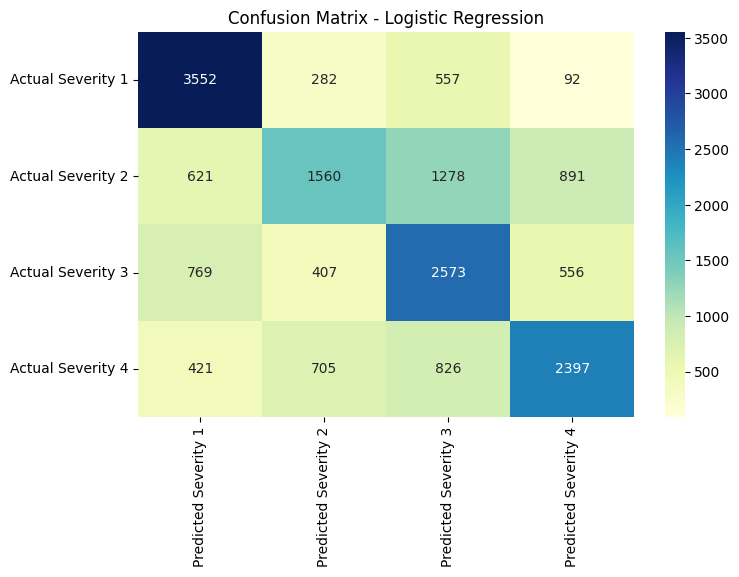

In [42]:
y_pred = lr.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

## Algorithms Evaluation

In [43]:
print(classification_report(y_train, lr.predict(X_train)))

              precision    recall  f1-score   support

           1       0.65      0.79      0.71     13041
           2       0.53      0.36      0.43     13081
           3       0.48      0.58      0.53     13178
           4       0.61      0.55      0.58     13161

    accuracy                           0.57     52461
   macro avg       0.57      0.57      0.56     52461
weighted avg       0.57      0.57      0.56     52461



In [44]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.66      0.79      0.72      4483
           2       0.53      0.36      0.43      4350
           3       0.49      0.60      0.54      4305
           4       0.61      0.55      0.58      4349

    accuracy                           0.58     17487
   macro avg       0.57      0.57      0.57     17487
weighted avg       0.57      0.58      0.57     17487



### Accuracy -  Logistic Regression

In [45]:
accuracy["Logistic Regression"] = accuracy_score(y_validate, y_pred)
print("Accuracy - Logistic Regression: ", accuracy["Logistic Regression"])

Accuracy - Logistic Regression:  0.5765425744839023


### F1-Score - Recall - Precision - Logistic Regression

In [46]:
f1["Logistic Regression"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Logistic Regression: ", f1["Logistic Regression"])
print("precision - Logistic Regression: ", precisionScore)
print("recall - Logistic Regression: ", recallScore)

f1-Score - Logistic Regression:  0.5666950268133106
precision - Logistic Regression:  0.5727501732335858
recall - Logistic Regression:  0.574946390698542


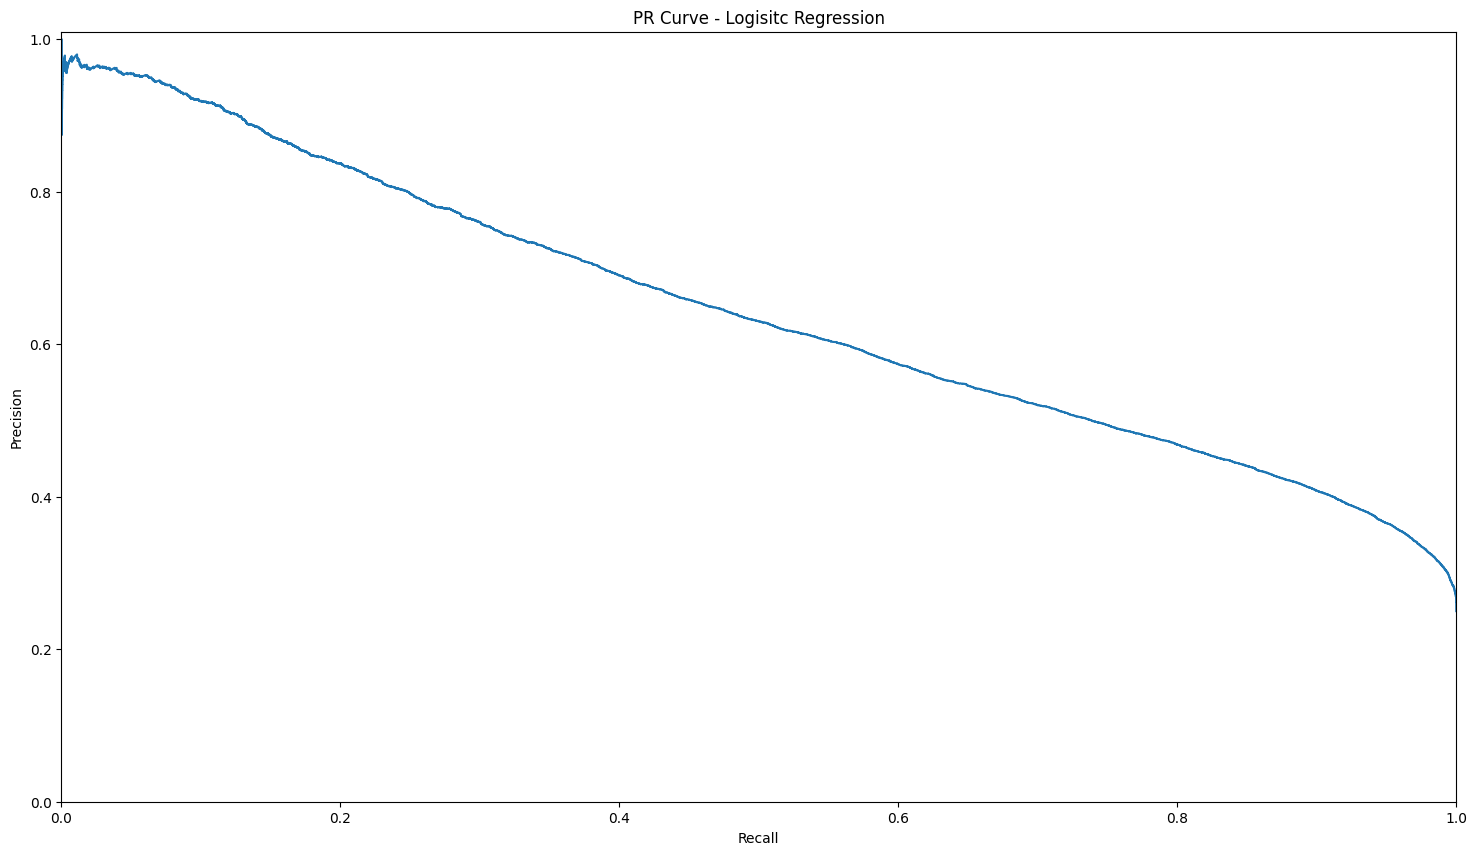

In [47]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = lr.predict_proba(X_validate)

precision["Logistic Regression"], recall["Logistic Regression"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Logistic Regression"], precision["Logistic Regression"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Logisitc Regression")
plt.show()

### ROC curve - Logistic Regression

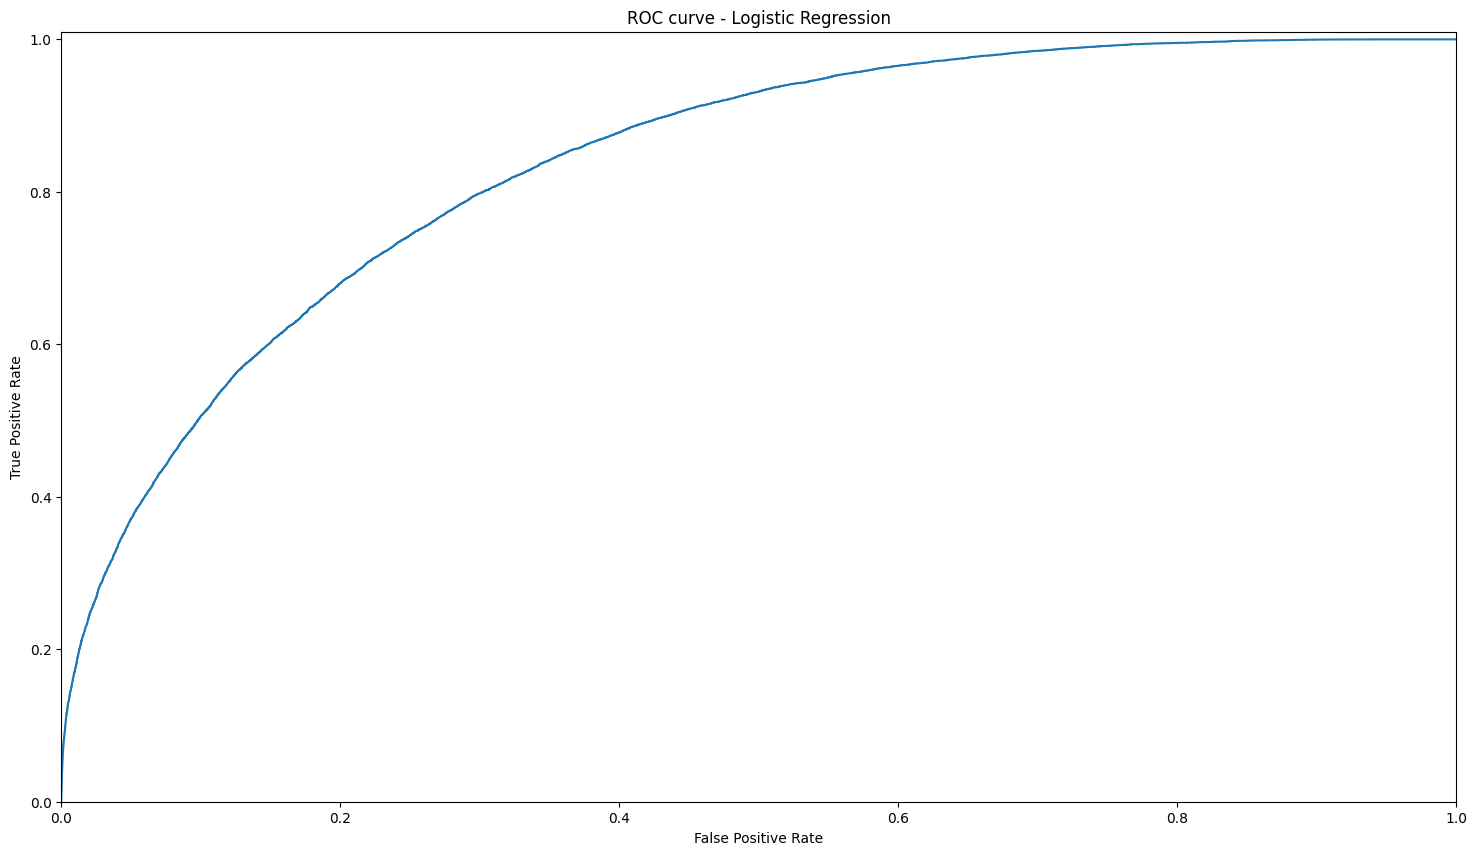

In [48]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = lr.predict_proba(X_validate)

fpr["Logistic Regression"], tpr["Logistic Regression"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Logistic Regression"], tpr["Logistic Regression"], where="post")

plt.title("ROC curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# 3.3. Decision Tree


## Intro

## Reasons

## Build and predict

In [49]:
dtc = DecisionTreeClassifier(random_state=42)
parameters = [{"criterion": ["gini", "entropy"], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(dtc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters scores:
{'criterion': 'gini', 'max_depth': 10}
Train score: 0.7796648939211986
Validation score: 0.7569051295247898


In [50]:
print("Default scores:")
dtc.fit(X_train, y_train)
print("Train score:", dtc.score(X_train, y_train))
print("Validation score:", dtc.score(X_validate, y_validate))

Default scores:
Train score: 0.9990659728179028
Validation score: 0.7126436781609196


In [51]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1       1.757633      0.400832         0.020368        0.005442   
2       1.796185      0.232739         0.021866        0.004785   
5       1.423605      0.132746         0.021623        0.007614   
6       1.898234      0.126121         0.012605        0.004869   
3       2.094533      0.445174         0.016208        0.001661   
7       1.817460      0.130254         0.014307        0.005379   
0       0.876799      0.213477         0.023279        0.004834   
4       0.881558      0.185700         0.016318        0.003695   

  param_criterion param_max_depth                                     params  \
1            gini              10     {'criterion': 'gini', 'max_depth': 10}   
2            gini              15     {'criterion': 'gini', 'max_depth': 15}   
5         entropy              10  {'criterion': 'entropy', 'max_depth': 10}   
6         entropy              15  {'criterion': 'entropy', 'max_depth': 15}   
3            gini              30     {'criterion': 'gini', 'max_depth': 30}   
7         entropy              30  {'criterion': 'entropy', 'max_depth': 30}   
0            gini               5      {'criterion': 'gini', 'max_depth': 5}   
4         entropy               5   {'criterion': 'entropy', 'max_depth': 5}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
1           0.740017           0.751239           0.746569           0.749714   
2           0.741637           0.750477           0.746664           0.743042   
5           0.732488           0.747045           0.737324           0.739039   
6           0.731345           0.734083           0.727697           0.739230   
3           0.711808           0.713782           0.711018           0.705013   
7           0.707996           0.712066           0.710827           0.715021   
0           0.695416           0.700724           0.697960           0.694624   
4           0.689507           0.692623           0.691860           0.690145   

   split4_test_score  mean_test_score  std_test_score  rank_test_score  
1           0.752669         0.748042        0.004494                1  
2           0.754384         0.747241        0.004709                2  
5           0.740564         0.739292        0.004732                3  
6           0.729318         0.732335        0.004054                4  
3           0.713115         0.710947        0.003121                5  
7           0.708349         0.710852        0.002580                6  
0           0.698342         0.697413        0.002186                7  
4           0.693195         0.691466        0.001419                8

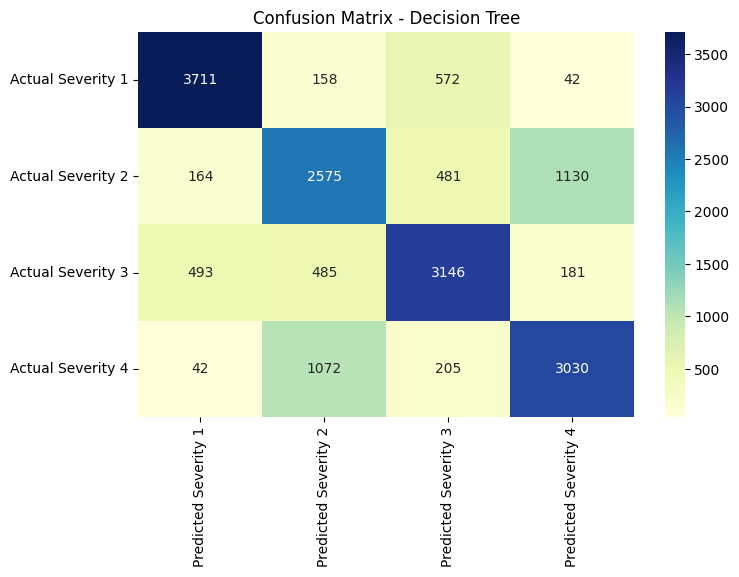

In [52]:
y_pred = dtc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Decision Tree")
plt.show()

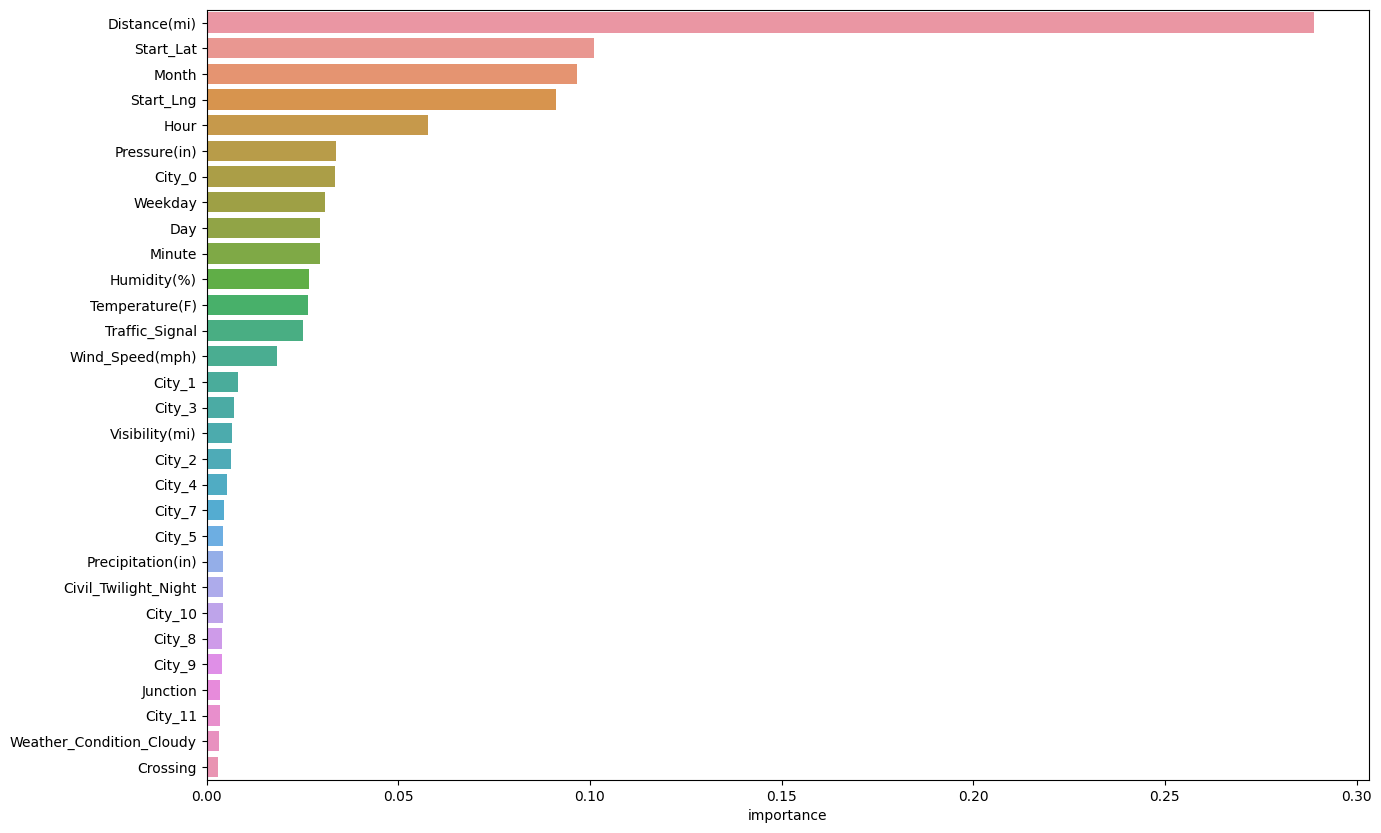

In [53]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = dtc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

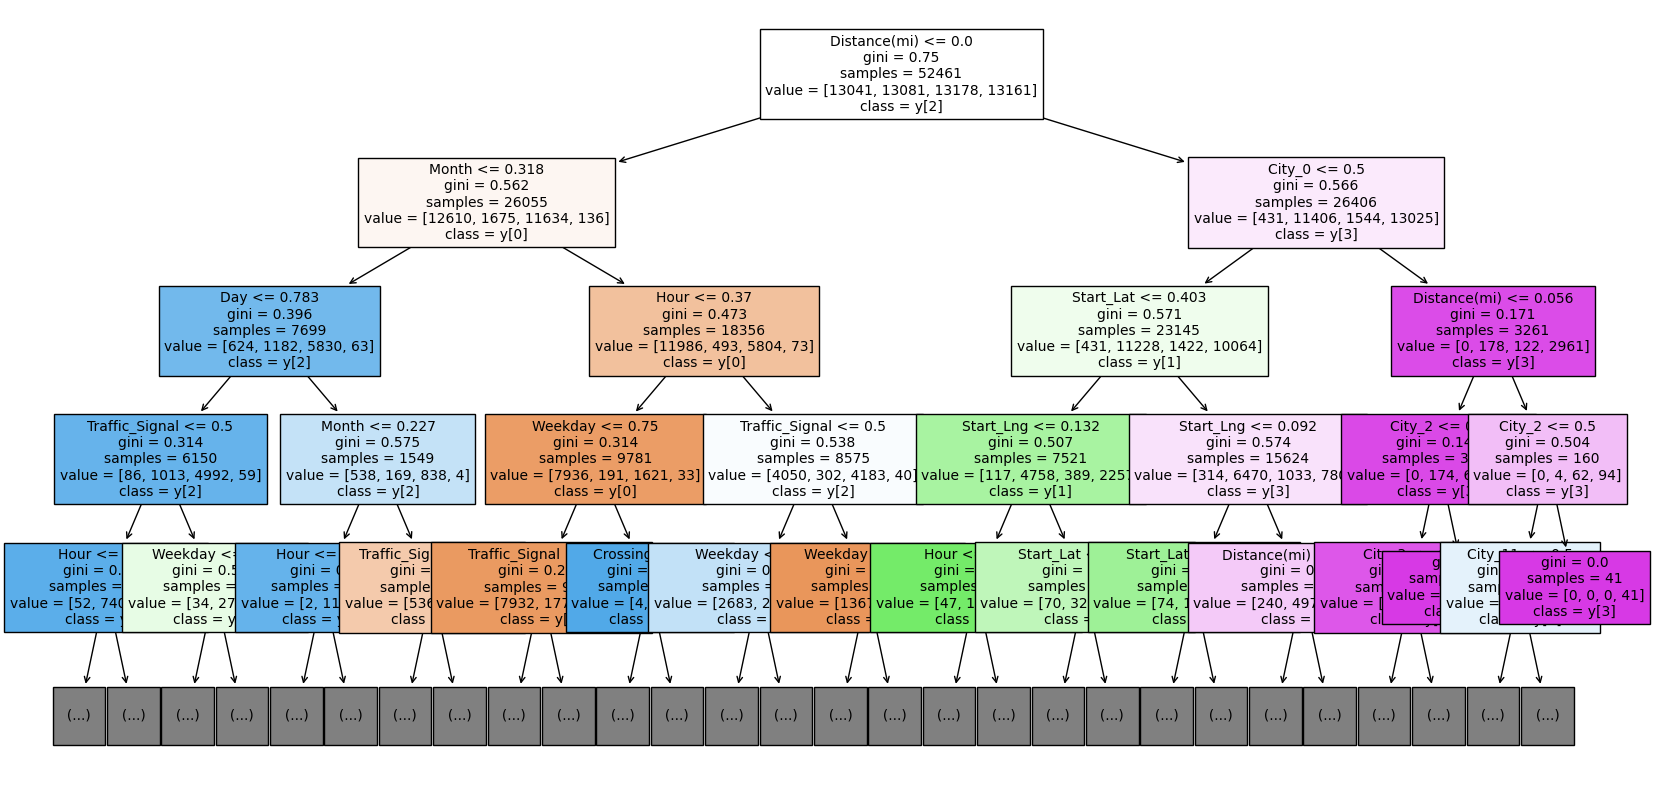

In [54]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(dtc, max_depth=4, fontsize=10, feature_names=X_train.columns.to_list(), class_names = True, filled=True)
plt.show()

## Algorithms Evaluation

In [55]:
print(classification_report(y_train, dtc.predict(X_train)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     13041
           2       1.00      1.00      1.00     13081
           3       1.00      1.00      1.00     13178
           4       1.00      1.00      1.00     13161

    accuracy                           1.00     52461
   macro avg       1.00      1.00      1.00     52461
weighted avg       1.00      1.00      1.00     52461



In [56]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.84      0.83      0.83      4483
           2       0.60      0.59      0.60      4350
           3       0.71      0.73      0.72      4305
           4       0.69      0.70      0.69      4349

    accuracy                           0.71     17487
   macro avg       0.71      0.71      0.71     17487
weighted avg       0.71      0.71      0.71     17487



### Accuracy - Decision Tree

In [57]:
accuracy["Decision Tree"] = accuracy_score(y_validate, y_pred)
print("Accuracy - Decision Tree: ", accuracy["Decision Tree"])

Accuracy - Decision Tree:  0.7126436781609196


### F1-Score - Recall - Precision - Decision Tree

In [58]:
f1["Decision Tree"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Decision Tree: ", f1["Decision Tree"])
print("precision - Decision Tree: ", precisionScore)
print("recall - Decision Tree: ", recallScore)

f1-Score - Decision Tree:  0.7117809770587399
precision - Decision Tree:  0.7118469032489501
recall - Decision Tree:  0.7118094909311807


Draw PR (Precision - Recall) Curve - Decision Tree

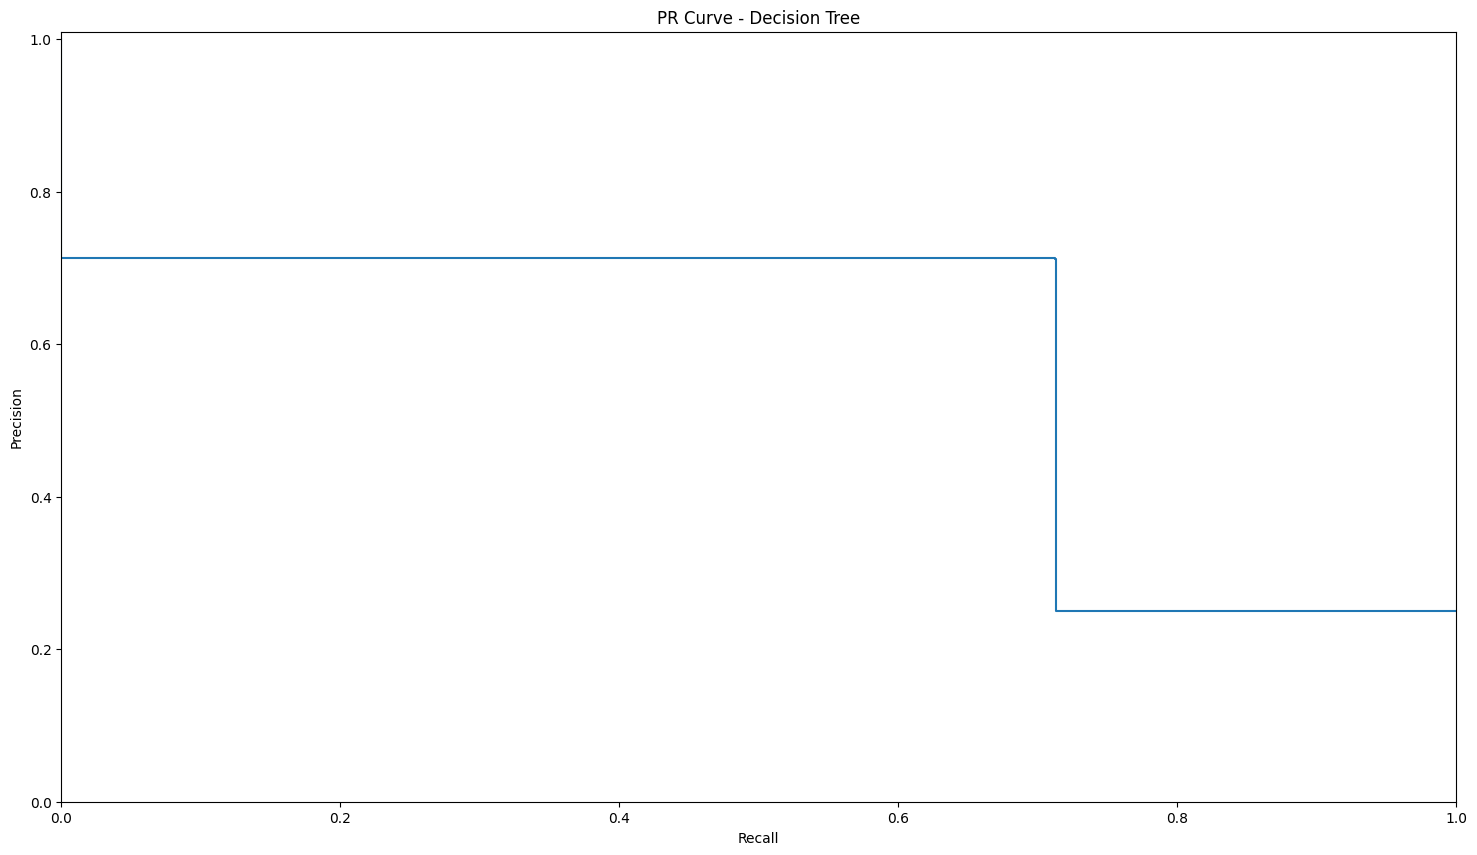

In [59]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = dtc.predict_proba(X_validate)

precision["Decision Tree"], recall["Decision Tree"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Decision Tree"], precision["Decision Tree"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Decision Tree")
plt.show()

### ROC curve - Decision Tree

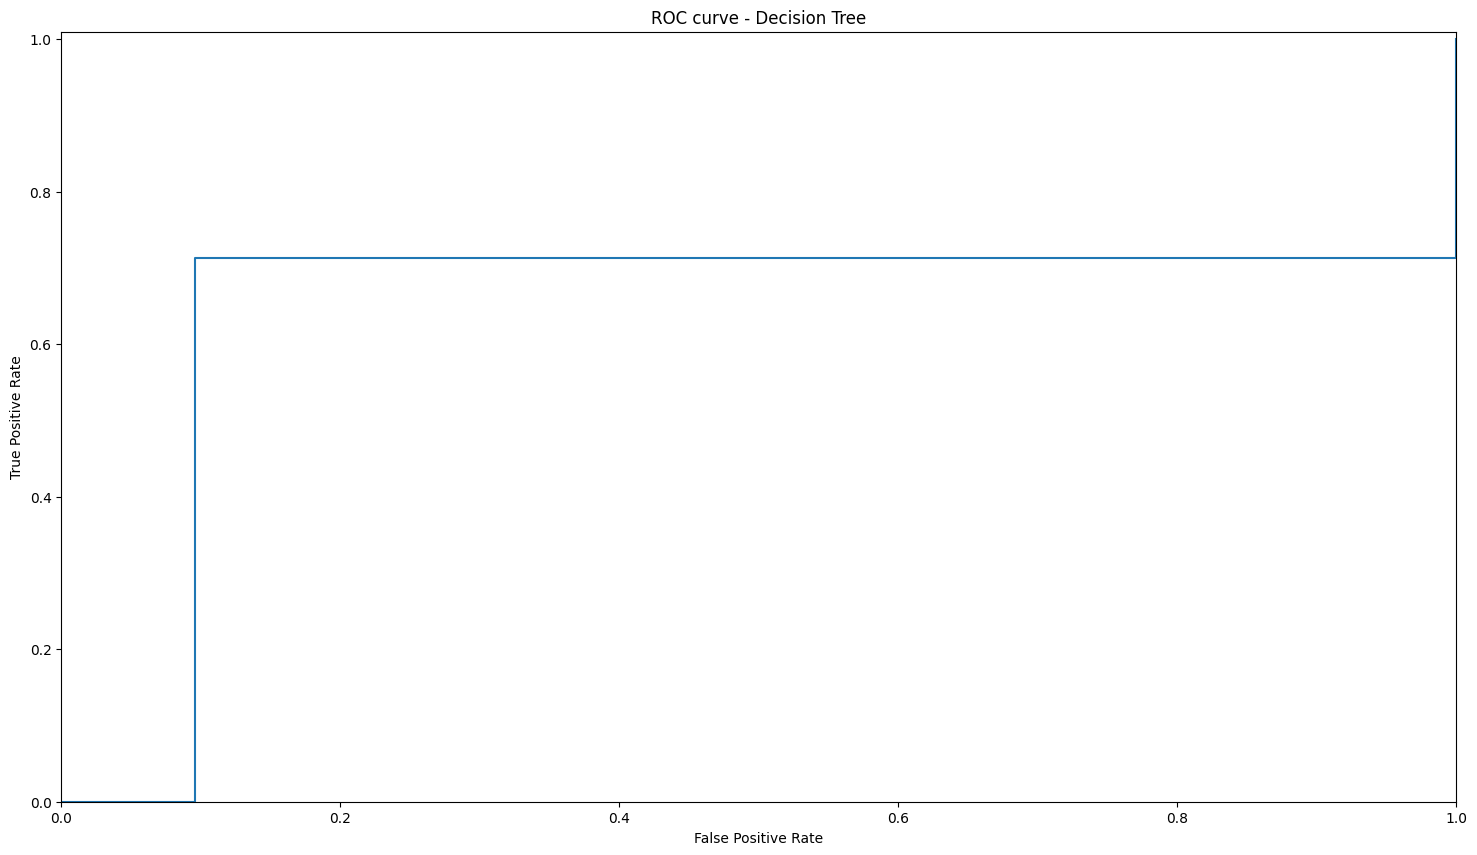

In [60]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = dtc.predict_proba(X_validate)

fpr["Decision Tree"], tpr["Decision Tree"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Decision Tree"], tpr["Decision Tree"], where="post")

plt.title("ROC curve - Decision Tree")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# 3.4. Random Forest


## Intro

## Reasons

## Build and predict

In [61]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)
parameters = [{"n_estimators": [50, 100, 200, 500], "max_depth": [5, 10, 15, 30]}]
grid = GridSearchCV(rfc, parameters, verbose=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters scores:")
print(grid.best_params_)
print("Train score:", grid.score(X_train, y_train))
print("Validation score:", grid.score(X_validate, y_validate))

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters scores:
{'max_depth': 30, 'n_estimators': 500}
Train score: 0.9990659728179028
Validation score: 0.7948190084062446


In [62]:
print("Default scores:")
rfc.fit(X_train, y_train)
print("Train score:", rfc.score(X_train, y_train))
print("Validation score:", rfc.score(X_validate, y_validate))

Default scores:
Train score: 0.9990659728179028
Validation score: 0.7908160347686853


In [63]:
pd.DataFrame(grid.cv_results_).sort_values(by="rank_test_score")

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
15      62.510663      0.454332         2.306070        0.865265   
14      31.603313      0.855034         7.052362        1.598506   
13      23.582978      2.046871         5.624114        0.650845   
12      15.934056      2.891402         7.700938        1.182978   
11      62.915107      0.752123         4.812870        0.282922   
10      26.435081      3.758264         7.199493        1.737640   
9       17.126439      2.602779         2.776752        0.563076   
8       12.959793      1.022784         6.370185        1.078274   
6       15.361044      2.571432         6.515377        1.066229   
7       41.635237      0.251628         3.058950        0.307654   
5        9.816089      1.747841         2.570283        0.855021   
4        8.046254      0.744045         4.784849        0.466444   
3       19.827653      0.984218         3.065774        1.220467   
2        6.561417      0.177018         4.604177        0.711827   
1        3.566911      1.288721         2.137040        0.723793   
0        2.492982      0.933252         2.105819        0.643805   

   param_max_depth param_n_estimators                                  params  \
15              30                500  {'max_depth': 30, 'n_estimators': 500}   
14              30                200  {'max_depth': 30, 'n_estimators': 200}   
13              30                100  {'max_depth': 30, 'n_estimators': 100}   
12              30                 50   {'max_depth': 30, 'n_estimators': 50}   
11              15                500  {'max_depth': 15, 'n_estimators': 500}   
10              15                200  {'max_depth': 15, 'n_estimators': 200}   
9               15                100  {'max_depth': 15, 'n_estimators': 100}   
8               15                 50   {'max_depth': 15, 'n_estimators': 50}   
6               10                200  {'max_depth': 10, 'n_estimators': 200}   
7               10                500  {'max_depth': 10, 'n_estimators': 500}   
5               10                100  {'max_depth': 10, 'n_estimators': 100}   
4               10                 50   {'max_depth': 10, 'n_estimators': 50}   
3                5                500   {'max_depth': 5, 'n_estimators': 500}   
2                5                200   {'max_depth': 5, 'n_estimators': 200}   
1                5                100   {'max_depth': 5, 'n_estimators': 100}   
0                5                 50    {'max_depth': 5, 'n_estimators': 50}   

    split0_test_score  split1_test_score  split2_test_score  \
15           0.773182           0.793176           0.784026   
14           0.771371           0.793271           0.782978   
13           0.771467           0.786504           0.776878   
12           0.768894           0.783454           0.774400   
11           0.763652           0.784788           0.774114   
10           0.765272           0.782787           0.773923   
9            0.764224           0.780404           0.770968   
8            0.758124           0.780118           0.769253   
6            0.747355           0.762200           0.754956   
7            0.747546           0.764392           0.752478   
5            0.746212           0.759531           0.755337   
4            0.747546           0.757434           0.752859   
3            0.714858           0.727411           0.717499   
2            0.710760           0.725696           0.717785   
1            0.712475           0.722836           0.718262   
0            0.706566           0.717785           0.714544   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
15           0.780213           0.780690         0.782257        0.006501   
14           0.779546           0.777545         0.780942        0.007228   
13           0.778212           0.773446         0.777301        0.005188   
12           0.773732           0.772112         0.774518        0.004856   
11          

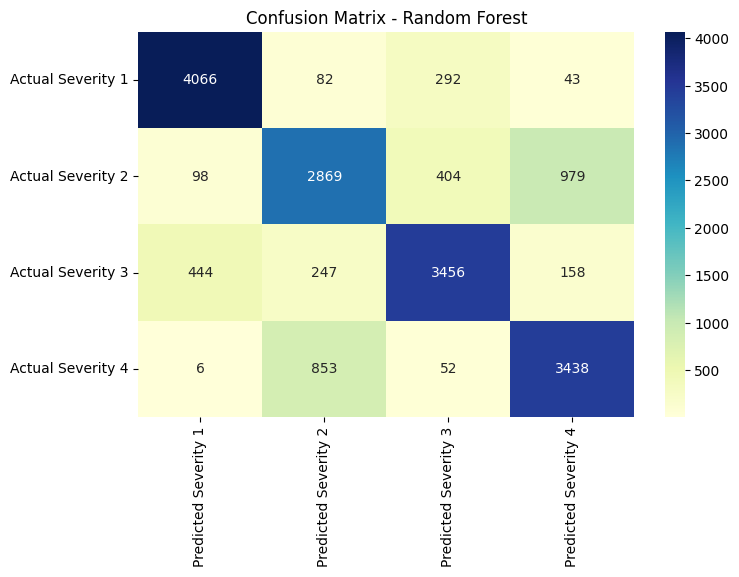

In [64]:
y_pred = rfc.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest")
plt.show()

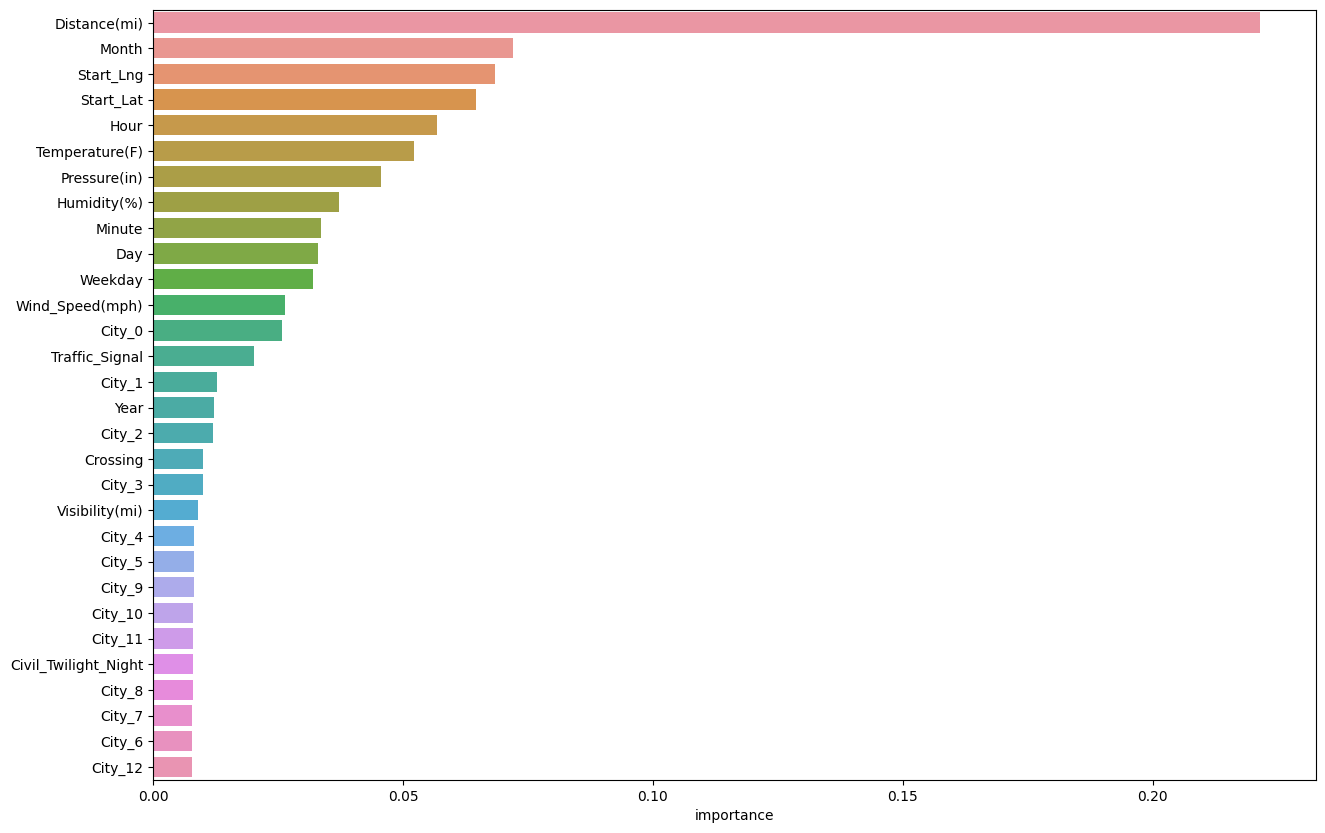

In [65]:
importances = pd.DataFrame(np.zeros((X_train.shape[1], 1)), columns=["importance"], index=X_train.columns)

importances.iloc[:,0] = rfc.feature_importances_

importances = importances.sort_values(by="importance", ascending=False)[:30]

plt.figure(figsize=(15, 10))
sns.barplot(x="importance", y=importances.index, data=importances)
plt.show()

## Algorithms Evaluation

In [66]:
print(classification_report(y_train, rfc.predict(X_train)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     13041
           2       1.00      1.00      1.00     13081
           3       1.00      1.00      1.00     13178
           4       1.00      1.00      1.00     13161

    accuracy                           1.00     52461
   macro avg       1.00      1.00      1.00     52461
weighted avg       1.00      1.00      1.00     52461



In [67]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.88      0.91      0.89      4483
           2       0.71      0.66      0.68      4350
           3       0.82      0.80      0.81      4305
           4       0.74      0.79      0.77      4349

    accuracy                           0.79     17487
   macro avg       0.79      0.79      0.79     17487
weighted avg       0.79      0.79      0.79     17487



### Accuracy - Random Forest

In [68]:
accuracy["Random Forest"] = accuracy_score(y_validate, y_pred)
print("accuracy - Random Forest: ", accuracy["Random Forest"])

accuracy - Random Forest:  0.7908160347686853


### F1-Score - Recall - Precision - Random Forest

In [69]:
f1["Random Forest"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Random Forest: ", f1["Random Forest"])
print("precision - Random Forest: ", precisionScore)
print("recall - Random Forest: ", recallScore)

f1-Score - Random Forest:  0.7890157533464734
precision - Random Forest:  0.7890008931540029
recall - Random Forest:  0.7899590439756433


Draw PR (Precision - Recall) Curve - Decision Tree

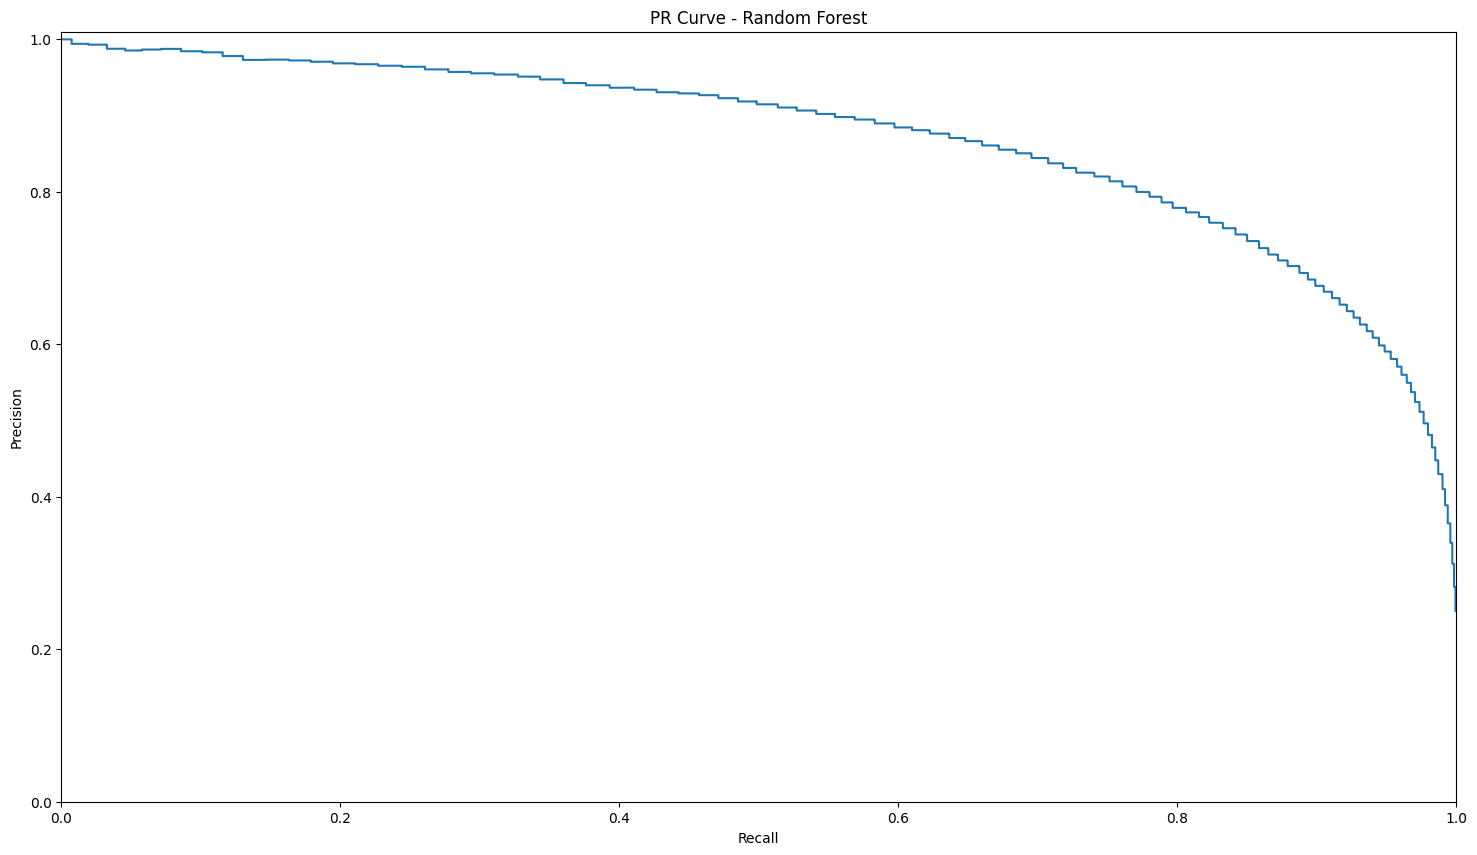

In [70]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_validate)

precision["Random Forest"], recall["Random Forest"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Random Forest"], precision["Random Forest"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Random Forest")
plt.show()

### ROC curve - Random Forest

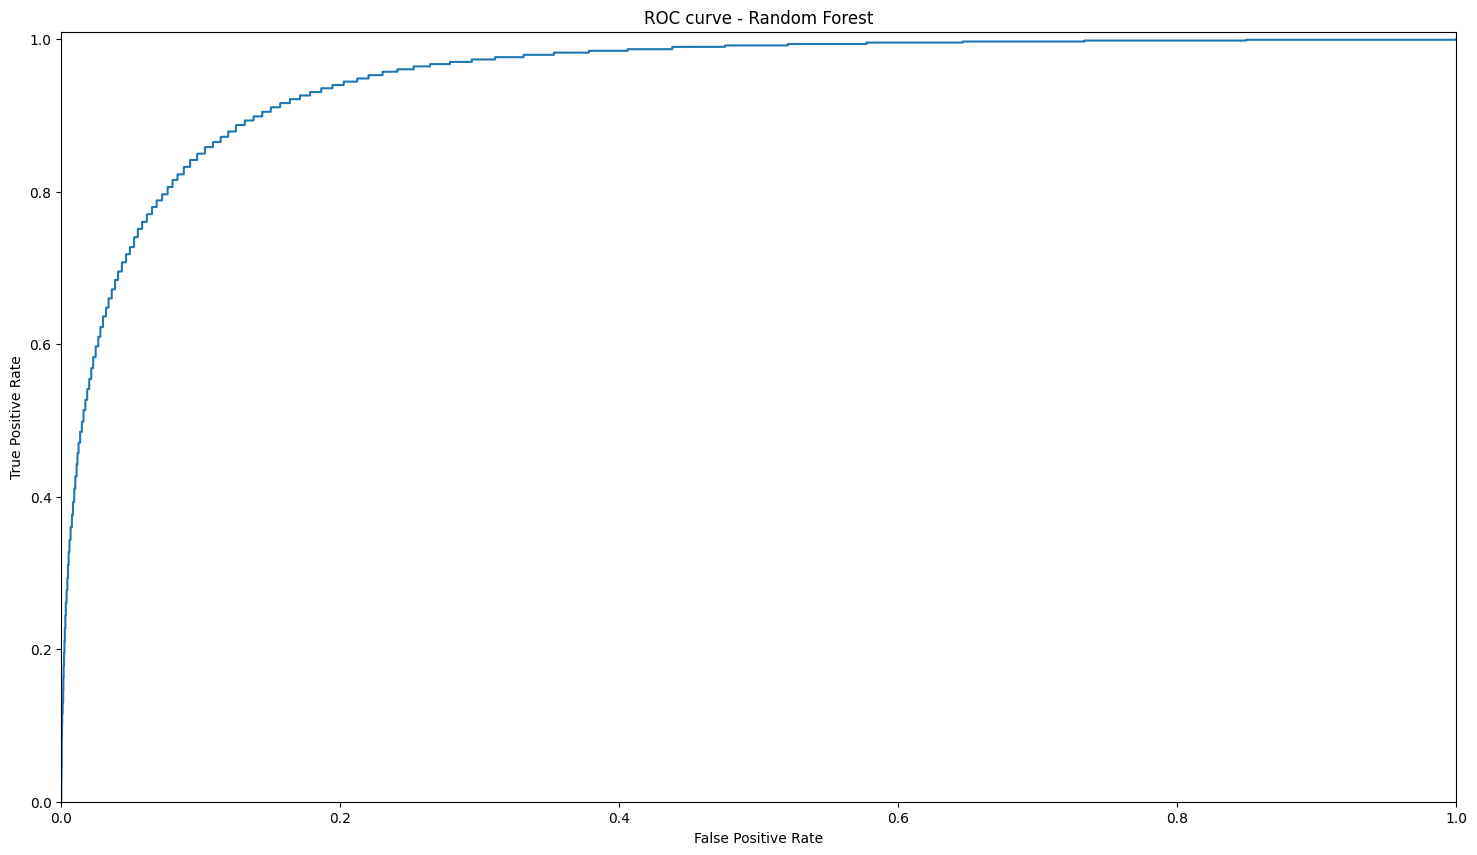

In [71]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = rfc.predict_proba(X_validate)
fpr["Random Forest"], tpr["Random Forest"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Random Forest"], tpr["Random Forest"], where="post")

plt.title("ROC curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# 3.5. Naive Bayes


## Intro

## Reason

## Built and predict - Gaussian Naive Bayes

In [72]:
from datetime import timedelta
import time
gnb_start_time = time.time()
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_end_time = time.time()
gnb_time = gnb_end_time - gnb_start_time
print("Train score:", gnb.score(X_train, y_train))
print("Validation score:", gnb.score(X_validate, y_validate))
print("Time is: ", timedelta(seconds=round(gnb_time,4)))


Train score: 0.3970377995082061
Validation score: 0.4035569280036599
Time is:  0:00:00.094200


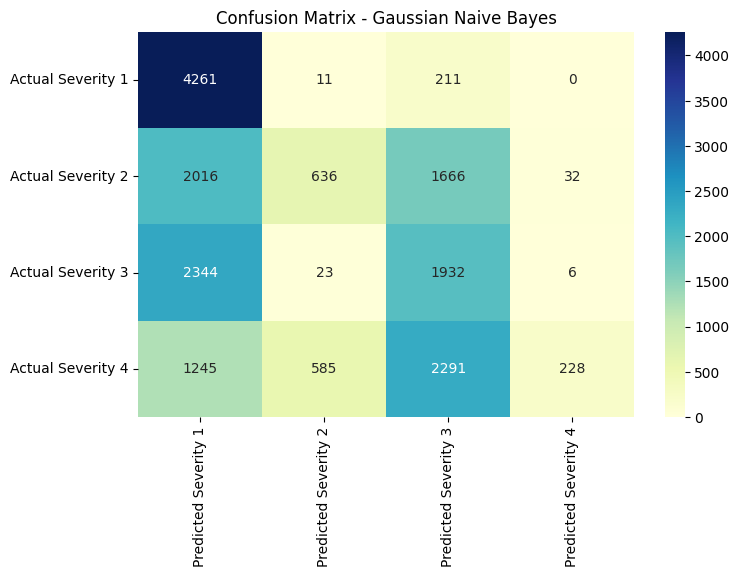

In [73]:
y_pred = gnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

## Algorithms Evaluation - Gaussian Naive Bayes

In [74]:
print(classification_report(y_train, gnb.predict(X_train)))

              precision    recall  f1-score   support

           1       0.42      0.95      0.58     13041
           2       0.52      0.15      0.23     13081
           3       0.32      0.45      0.37     13178
           4       0.87      0.05      0.10     13161

    accuracy                           0.40     52461
   macro avg       0.53      0.40      0.32     52461
weighted avg       0.53      0.40      0.32     52461



In [75]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.43      0.95      0.59      4483
           2       0.51      0.15      0.23      4350
           3       0.32      0.45      0.37      4305
           4       0.86      0.05      0.10      4349

    accuracy                           0.40     17487
   macro avg       0.53      0.40      0.32     17487
weighted avg       0.53      0.40      0.32     17487



### Accuracy -  Gaussian Naive Bayes

In [76]:
accuracy["Gaussian Naive Bayes"] = accuracy_score(y_validate, y_pred)
print("Accuracy - Gaussian Naive Bayes: ", accuracy["Gaussian Naive Bayes"])

Accuracy - Gaussian Naive Bayes:  0.4035569280036599


### F1-Score - Recall - Precision - Gaussian Naive Bayes

In [77]:
f1["Gaussian Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Gaussian Naive Bayes: ", f1["Gaussian Naive Bayes"])
print("precision - Gaussian Naive Bayes: ", precisionScore)
print("recall - Gaussian Naive Bayes: ", recallScore)

f1-Score - Gaussian Naive Bayes:  0.3227543430683913
precision - Gaussian Naive Bayes:  0.5281310916666341
recall - Gaussian Naive Bayes:  0.39947320473475206


Draw PR (Precision - Recall) Curve - Gaussian Naive Bayes

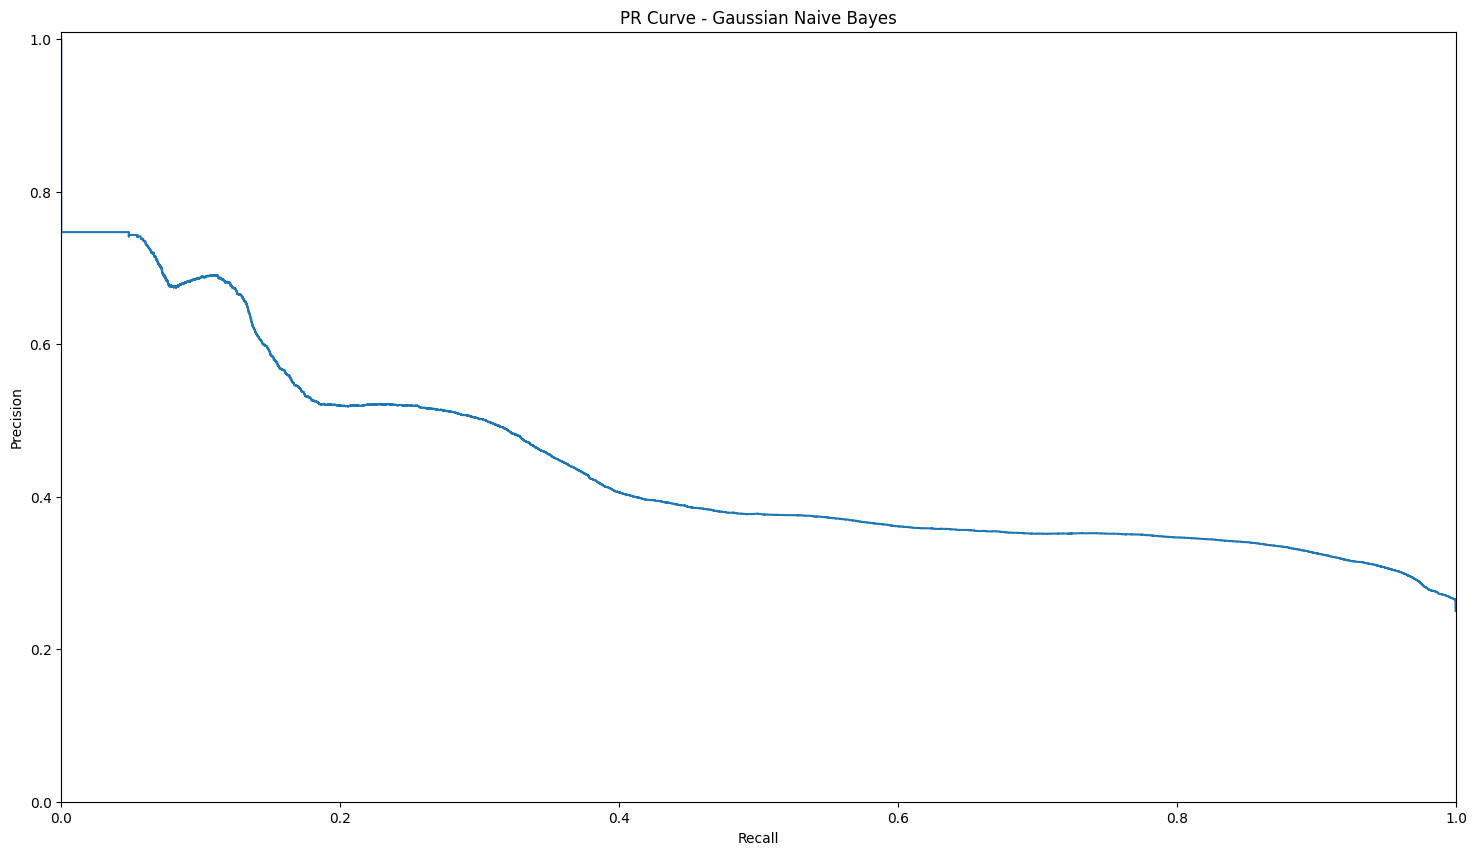

In [78]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = gnb.predict_proba(X_validate)

precision["Gaussian Naive Bayes"], recall["Gaussian Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Gaussian Naive Bayes"], precision["Gaussian Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Gaussian Naive Bayes")
plt.show()

### ROC curve - Gaussian Naive Bayes

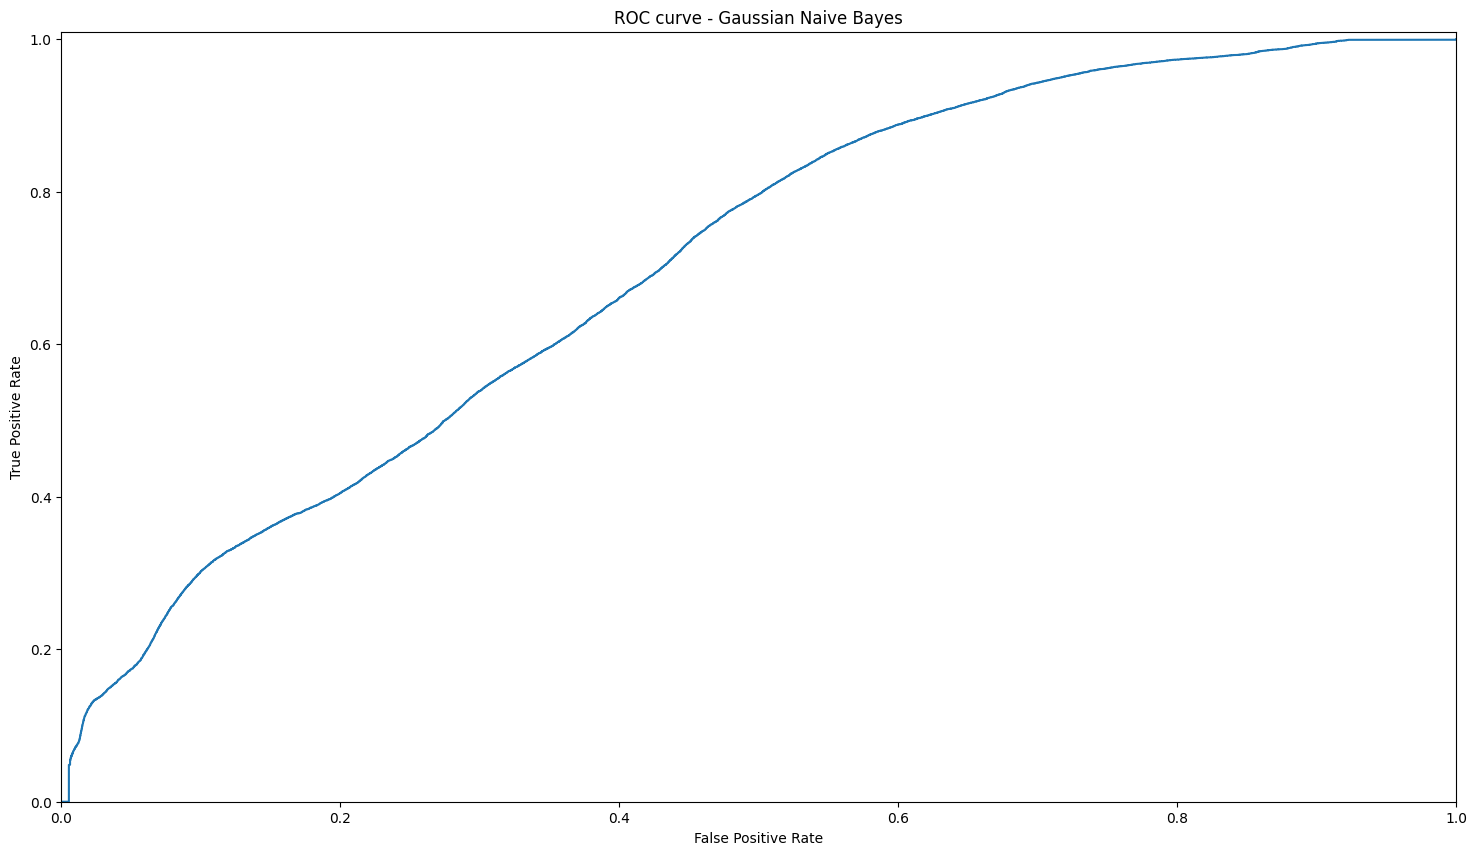

In [79]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = gnb.predict_proba(X_validate)

fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Gaussian Naive Bayes"], tpr["Gaussian Naive Bayes"], where="post")

plt.title("ROC curve - Gaussian Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Built and predict - Multinomial Naive Bayes

In [80]:
mnb_start_time = time.time()
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
mnb_end_time = time.time()
mnb_time = mnb_end_time - mnb_start_time

print("Train score:", mnb.score(X_train, y_train))
print("Validation score:", mnb.score(X_validate, y_validate))
print("Time is: ", timedelta(seconds=round(mnb_time,4)))

Train score: 0.48517946665141726
Validation score: 0.4891633785097501
Time is:  0:00:00.024700


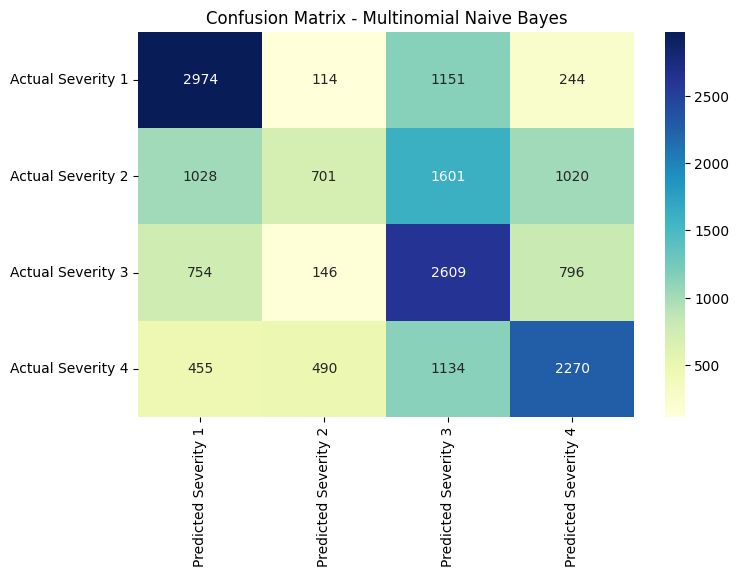

In [81]:
y_pred = mnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()

## Algorithms Evaluation - Multinomial Naive Bayes

In [82]:
print(classification_report(y_train, mnb.predict(X_train)))

              precision    recall  f1-score   support

           1       0.56      0.66      0.61     13041
           2       0.47      0.16      0.24     13081
           3       0.40      0.60      0.48     13178
           4       0.53      0.52      0.53     13161

    accuracy                           0.49     52461
   macro avg       0.49      0.49      0.46     52461
weighted avg       0.49      0.49      0.46     52461



In [83]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.57      0.66      0.61      4483
           2       0.48      0.16      0.24      4350
           3       0.40      0.61      0.48      4305
           4       0.52      0.52      0.52      4349

    accuracy                           0.49     17487
   macro avg       0.49      0.49      0.47     17487
weighted avg       0.50      0.49      0.47     17487



### Accuracy -  Multinomial Naive Bayes

In [84]:
accuracy["Multinomial Naive Bayes"] = accuracy_score(y_validate, y_pred)
print("Accuracy - Multinomial Naive Bayes: ", accuracy["Multinomial Naive Bayes"])

Accuracy - Multinomial Naive Bayes:  0.4891633785097501


### F1-Score - Recall - Precision - Multinomial Naive Bayes

In [85]:
f1["Multinomial Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Multinomial Naive Bayes: ", f1["Multinomial Naive Bayes"])
print("precision - Multinomial Naive Bayes: ", precisionScore)
print("recall - Multinomial Naive Bayes: ", recallScore)

f1-Score - Multinomial Naive Bayes:  0.46537694099709254
precision - Multinomial Naive Bayes:  0.4949434799138477
recall - Multinomial Naive Bayes:  0.48813575831586176


Draw PR (Precision - Recall) Curve - Multinomial Naive Bayes

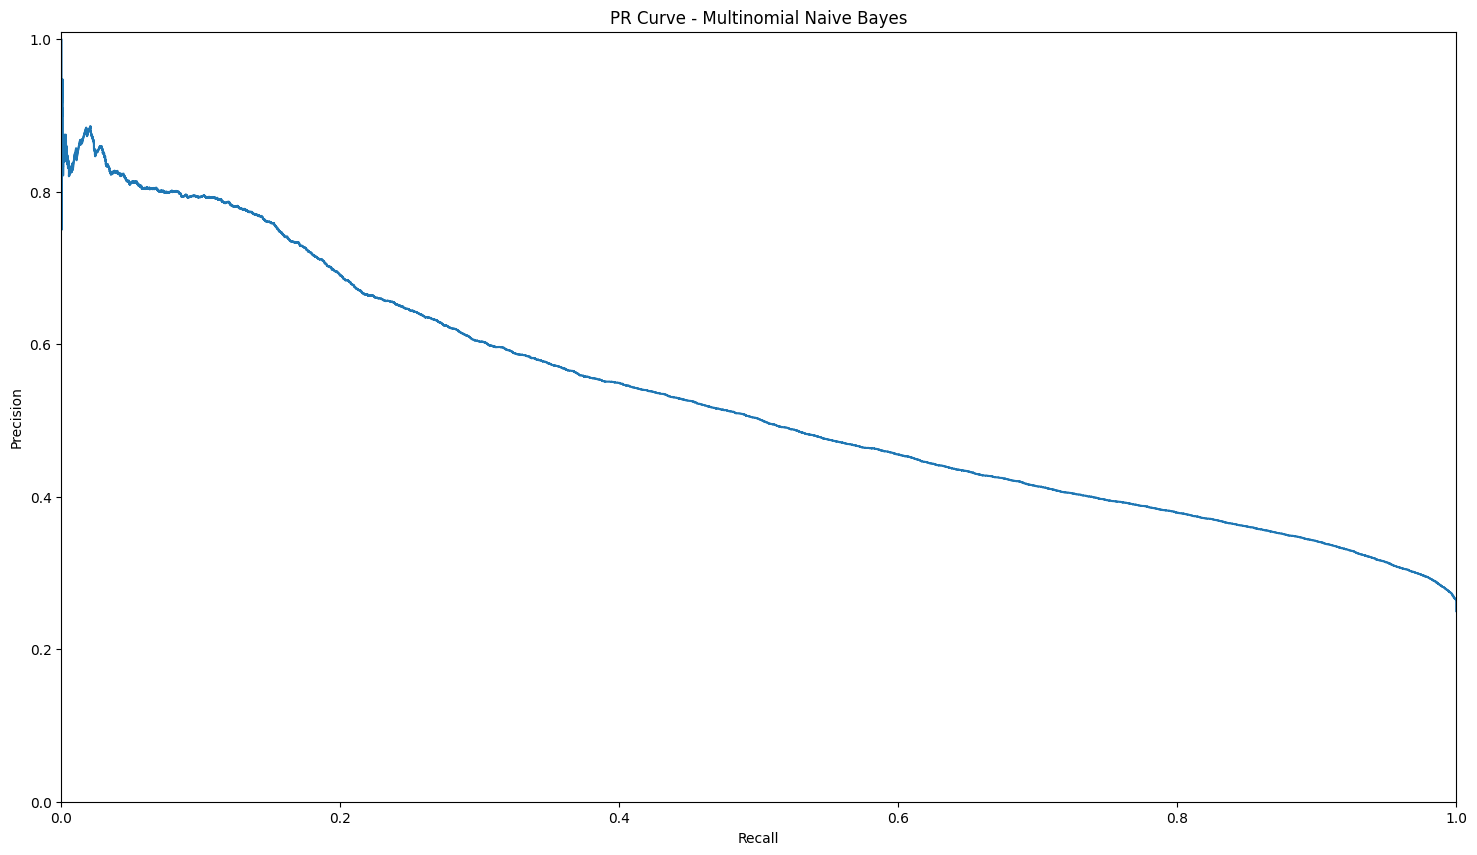

In [86]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = mnb.predict_proba(X_validate)

precision["Multinomial Naive Bayes"], recall["Multinomial Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Multinomial Naive Bayes"], precision["Multinomial Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Multinomial Naive Bayes")
plt.show()

### ROC curve - Multinomial Naive Bayes

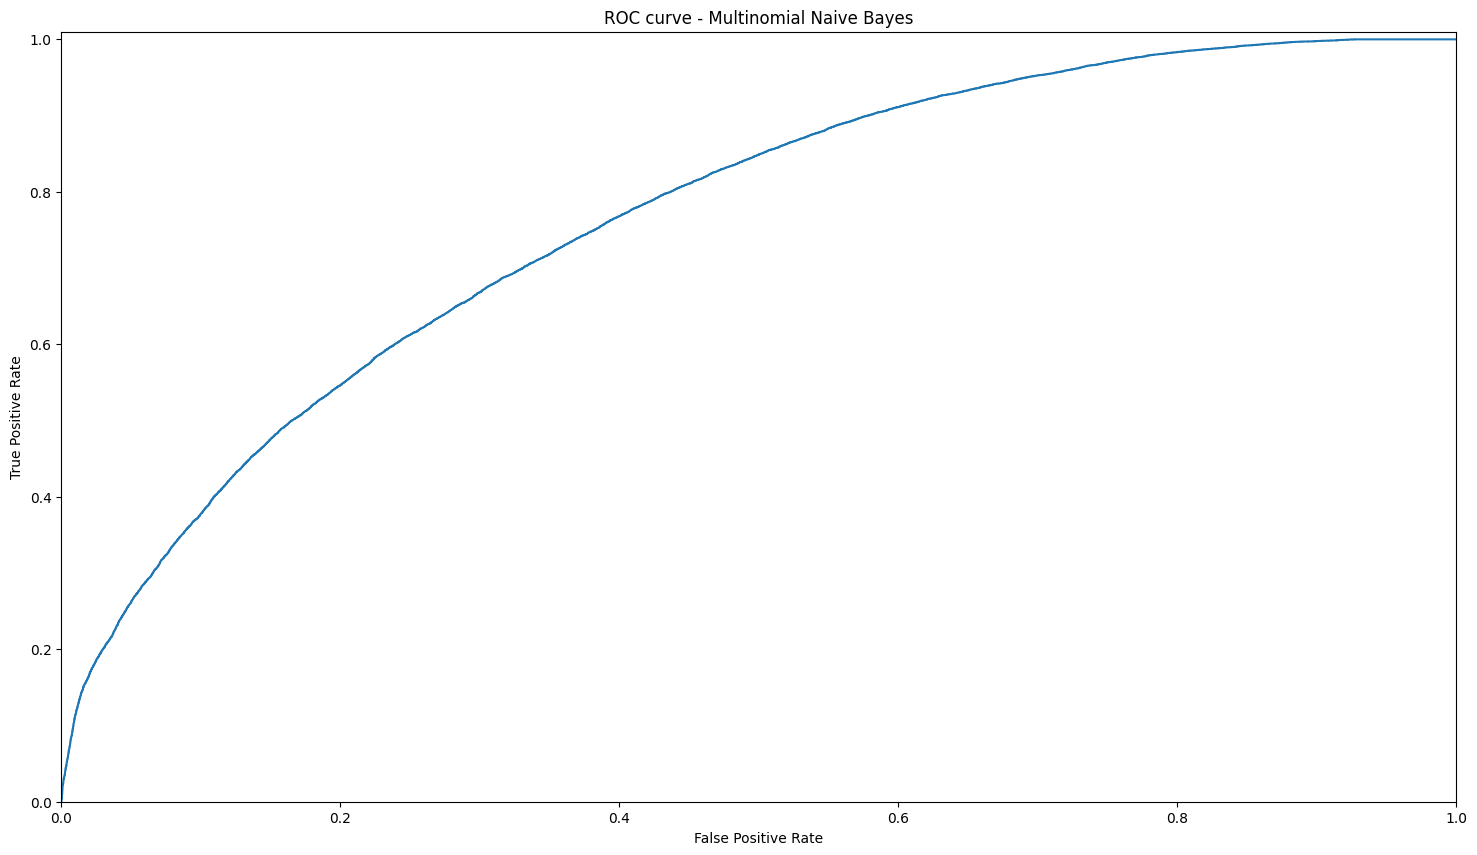

In [87]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = mnb.predict_proba(X_validate)

fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Multinomial Naive Bayes"], tpr["Multinomial Naive Bayes"], where="post")

plt.title("ROC curve - Multinomial Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

## Built and predict - Bernoulli Naive Bayes

In [88]:
bnb_start_time = time.time()
bnb = BernoulliNB()
bnb.fit(X_train, y_train)
bnb_end_time = time.time()
bnb_time = bnb_end_time - bnb_start_time
print("Train score:", bnb.score(X_train, y_train))
print("Validation score:", bnb.score(X_validate, y_validate))
print("Time is: ", timedelta(seconds=round(bnb_time,4)))

Train score: 0.6398276815157927
Validation score: 0.642420083490593
Time is:  0:00:00.066500


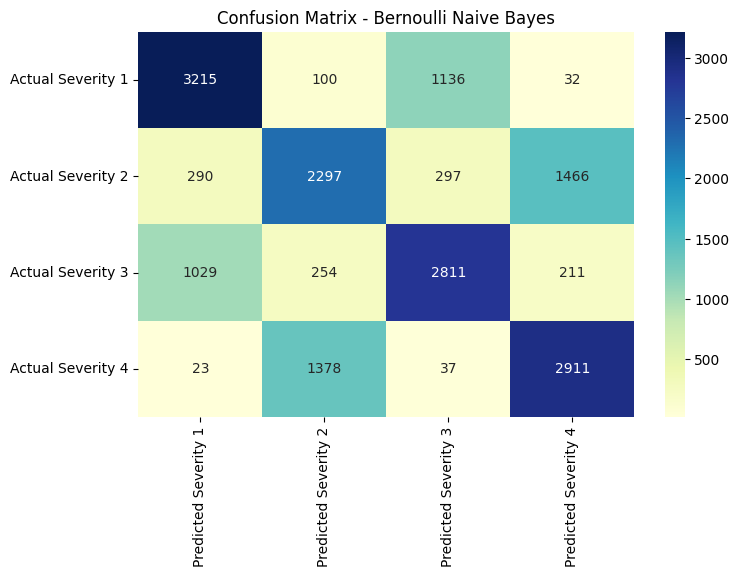

In [89]:
y_pred = bnb.predict(X_validate)
confmat = confusion_matrix(y_true=y_validate, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.show()

## Algorithm Evaluation - Bernoulli Naive Bayes

In [90]:
print(classification_report(y_train, bnb.predict(X_train)))

              precision    recall  f1-score   support

           1       0.70      0.71      0.70     13041
           2       0.57      0.54      0.55     13081
           3       0.66      0.65      0.65     13178
           4       0.63      0.67      0.65     13161

    accuracy                           0.64     52461
   macro avg       0.64      0.64      0.64     52461
weighted avg       0.64      0.64      0.64     52461



In [91]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           1       0.71      0.72      0.71      4483
           2       0.57      0.53      0.55      4350
           3       0.66      0.65      0.65      4305
           4       0.63      0.67      0.65      4349

    accuracy                           0.64     17487
   macro avg       0.64      0.64      0.64     17487
weighted avg       0.64      0.64      0.64     17487



### Accuracy -  Bernoulli Naive Bayes

In [92]:
accuracy["Bernoulli Naive Bayes"] = accuracy_score(y_validate, y_pred)
print("Accuracy - Bernoulli Naive Bayes: ", accuracy["Bernoulli Naive Bayes"])

Accuracy - Bernoulli Naive Bayes:  0.642420083490593


### F1-Score - Recall - Precision - Bernoulli Naive Bayes

In [93]:
f1["Bernoulli Naive Bayes"] = f1_score(y_validate, y_pred, average="macro")
precisionScore = precision_score(y_validate, y_pred, average="macro")
recallScore = recall_score(y_validate, y_pred, average="macro")
print("f1-Score - Bernoulli Naive Bayes: ", f1["Bernoulli Naive Bayes"])
print("precision - Bernoulli Naive Bayes: ", precisionScore)
print("recall - Bernoulli Naive Bayes: ", recallScore)

f1-Score - Bernoulli Naive Bayes:  0.6408675654446591
precision - Bernoulli Naive Bayes:  0.6405833821279147
recall - Bernoulli Naive Bayes:  0.6418776542263039


Draw PR (Precision - Recall) Curve - Bernoulli Naive Bayes

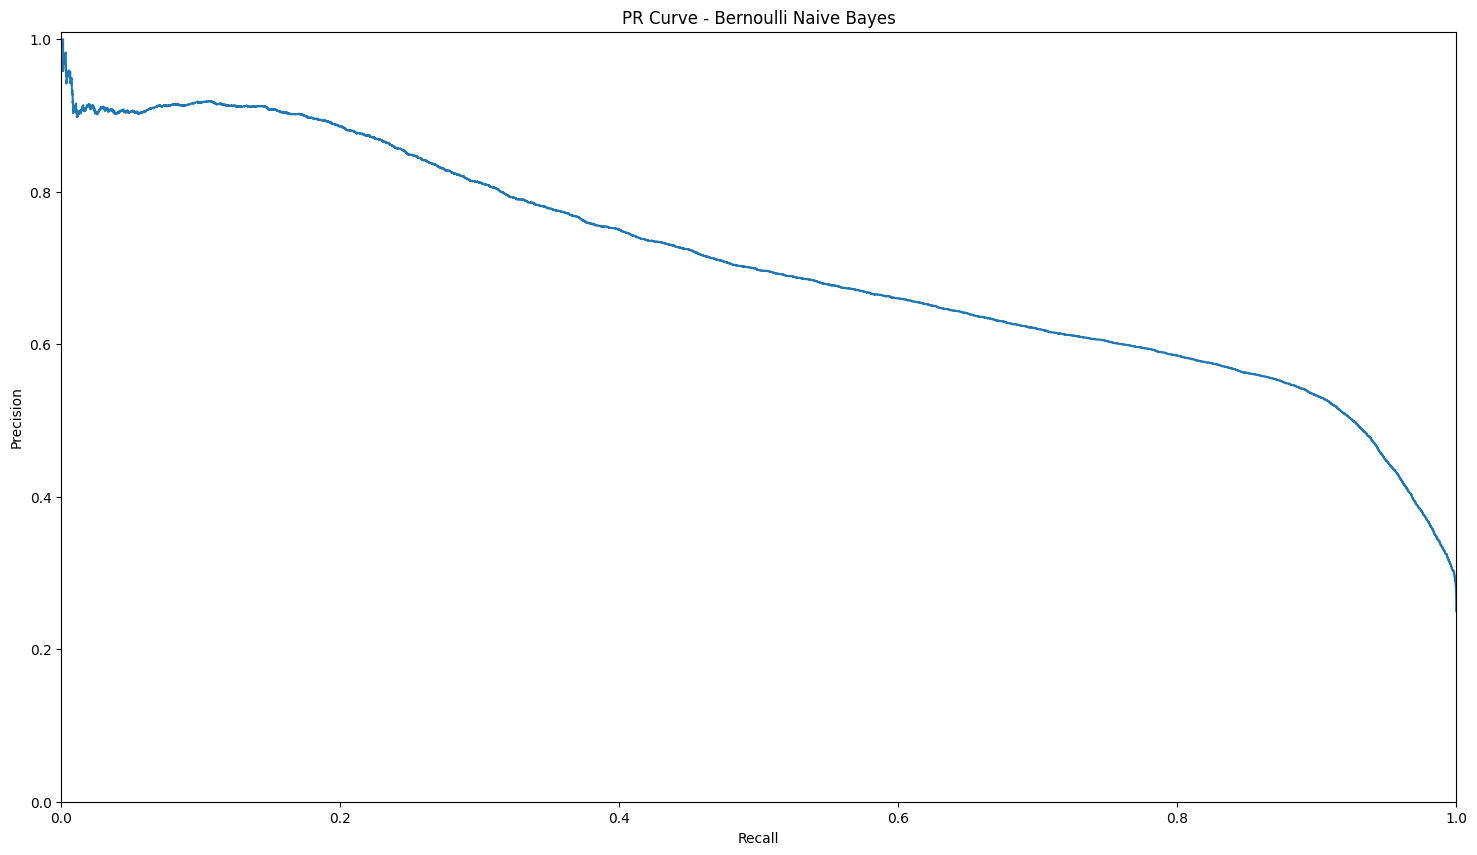

In [94]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])

y_score = bnb.predict_proba(X_validate)

precision["Bernoulli Naive Bayes"], recall["Bernoulli Naive Bayes"], _ = precision_recall_curve(Y.ravel(), y_score.ravel())
fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(recall["Bernoulli Naive Bayes"], precision["Bernoulli Naive Bayes"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR Curve - Bernoulli Naive Bayes")
plt.show()

### ROC curve - Bernoulli Naive Bayes

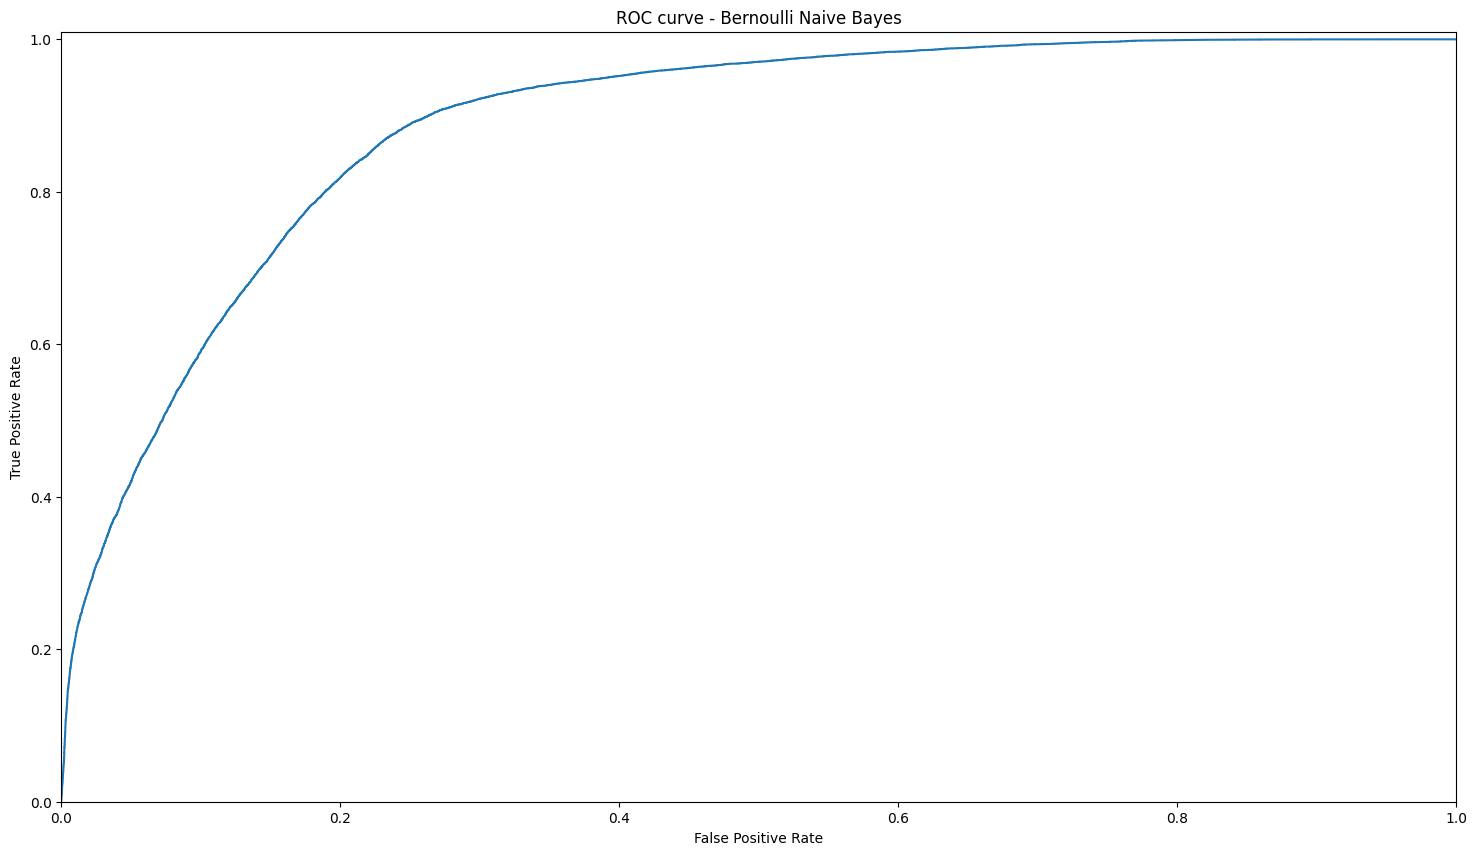

In [95]:
Y = label_binarize(y_validate, classes=[1, 2, 3, 4])
y_score = bnb.predict_proba(X_validate)

fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], _ = roc_curve(Y.ravel(), y_score.ravel())

plt.figure(figsize=(18, 10))
plt.step(fpr["Bernoulli Naive Bayes"], tpr["Bernoulli Naive Bayes"], where="post")

plt.title("ROC curve - Bernoulli Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.show()

# 4. PREDICTING

## 4.1. Algorithm Evaluation

### Accuracy

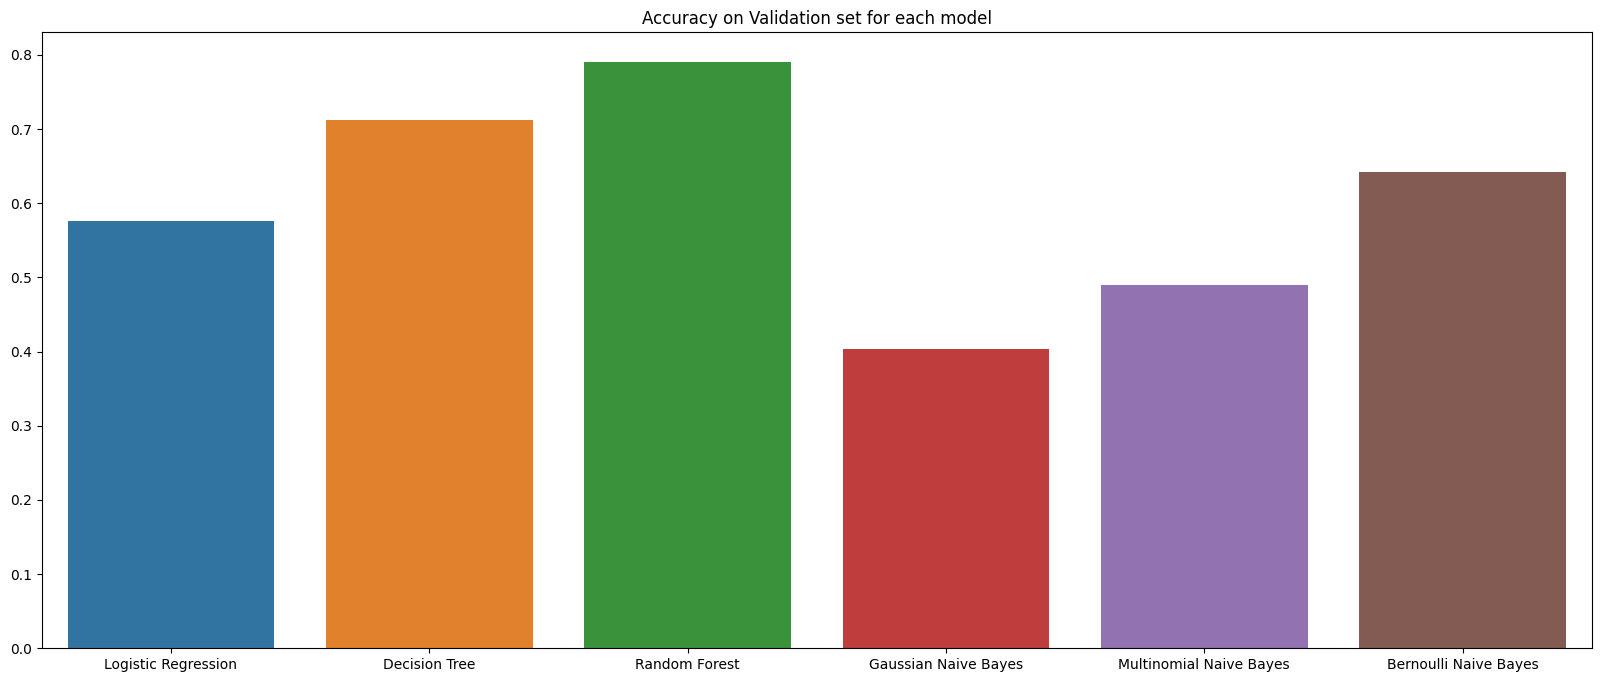

In [96]:
plt.figure(figsize=(20, 8))
plt.title("Accuracy on Validation set for each model")
sns.barplot(x = list(range(len(accuracy))), y = list(accuracy.values()))
plt.xticks(range(len(accuracy)), labels=accuracy.keys())
plt.show()

### F1 Score

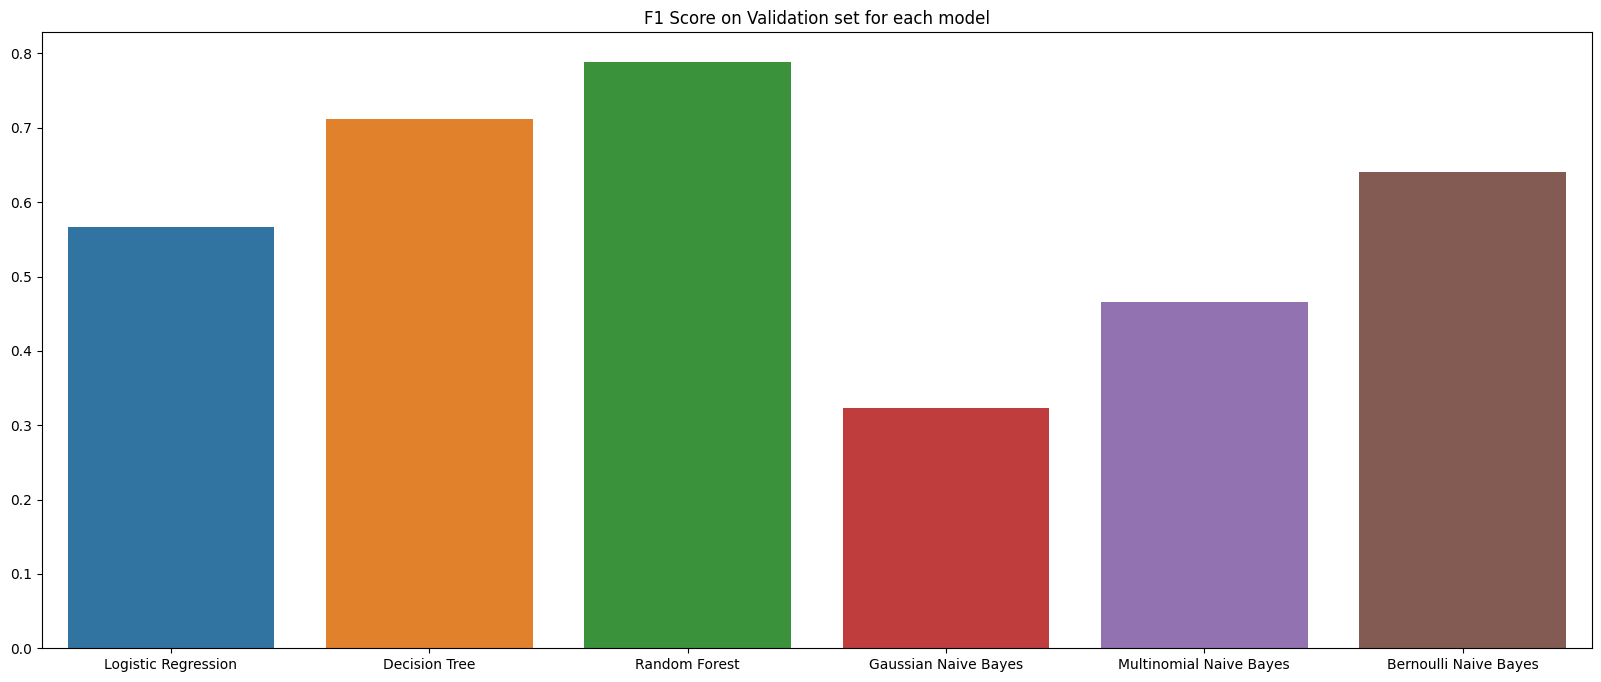

In [97]:
plt.figure(figsize=(20, 8))
plt.title("F1 Score on Validation set for each model")
sns.barplot(x =list(range(len(f1))), y =list(f1.values()))
plt.xticks(range(len(f1)), labels=f1.keys())
plt.show()

### Recall - Precision

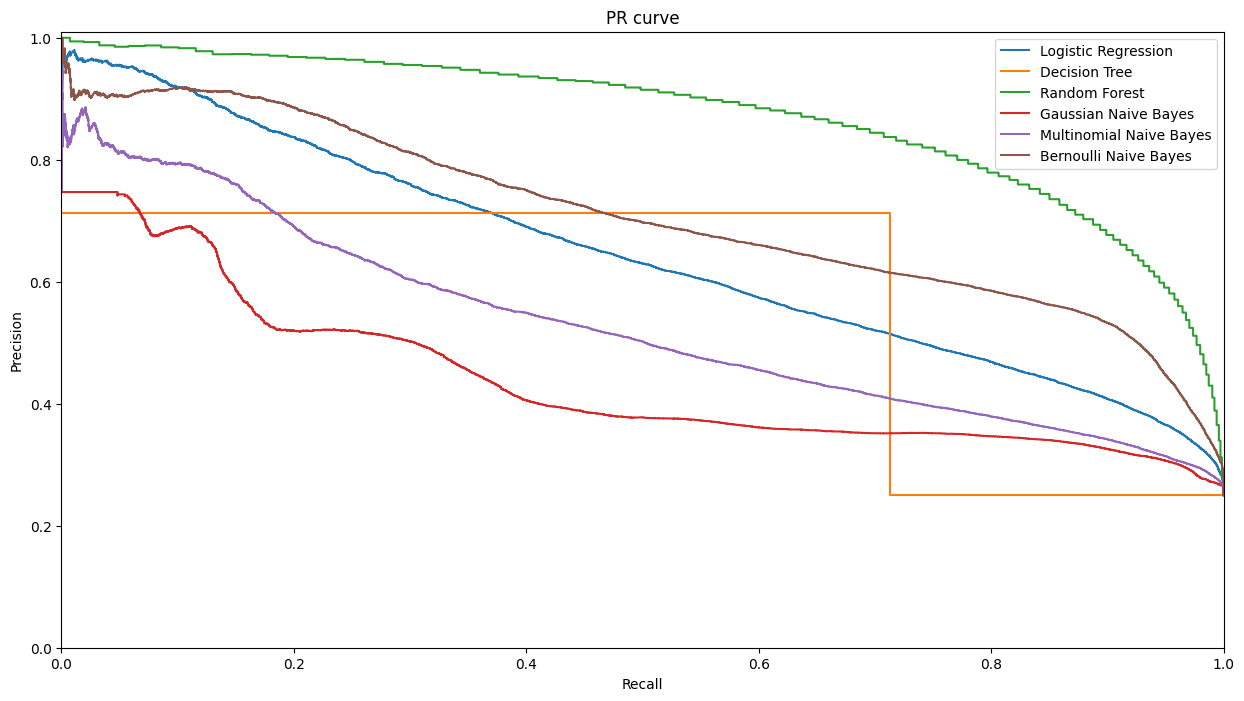

In [98]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(recall[key], precision[key], where="post", label=key)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("PR curve")
plt.legend()
plt.show()

### ROC curve

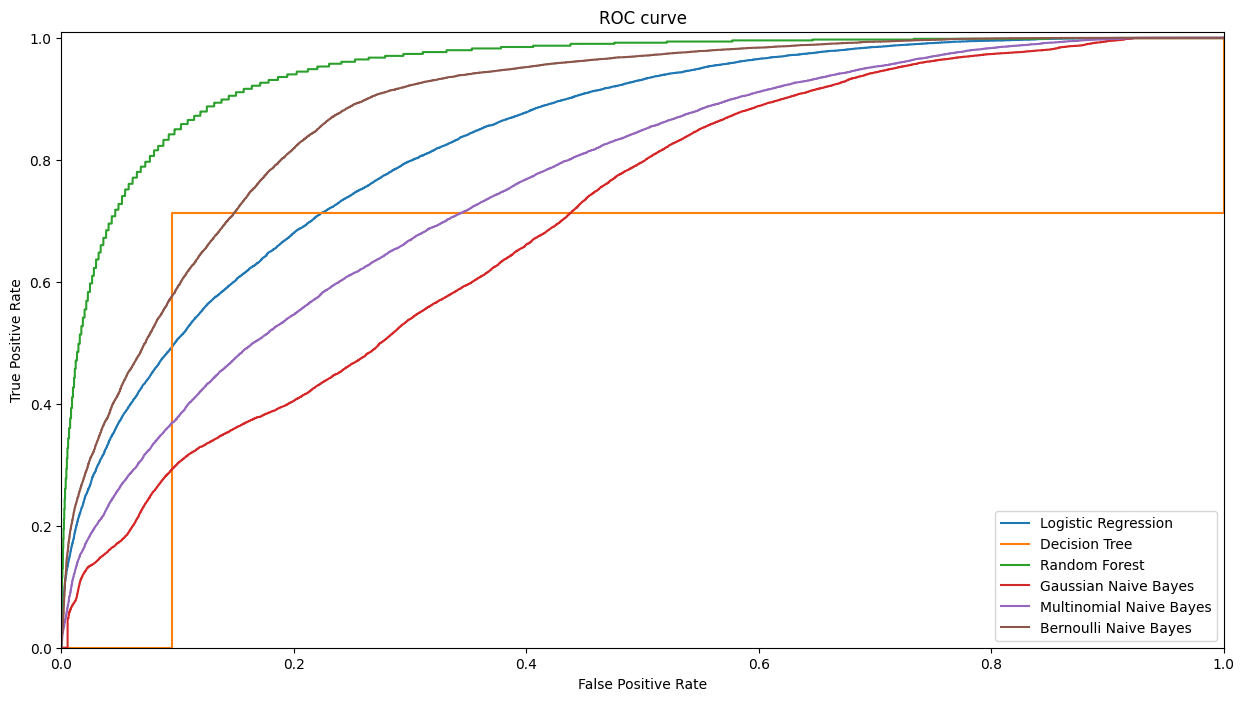

In [99]:
plt.figure(figsize=(15, 8))
for key in f1.keys():
    plt.step(fpr[key], tpr[key], where="post", label=key)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.title("ROC curve")
plt.legend()
plt.show()

## Predict - Using random Forest

              precision    recall  f1-score   support

           1       0.87      0.91      0.89      4335
           2       0.71      0.66      0.68      4428
           3       0.83      0.79      0.81      4376
           4       0.73      0.79      0.76      4349

    accuracy                           0.79     17488
   macro avg       0.79      0.79      0.79     17488
weighted avg       0.79      0.79      0.79     17488



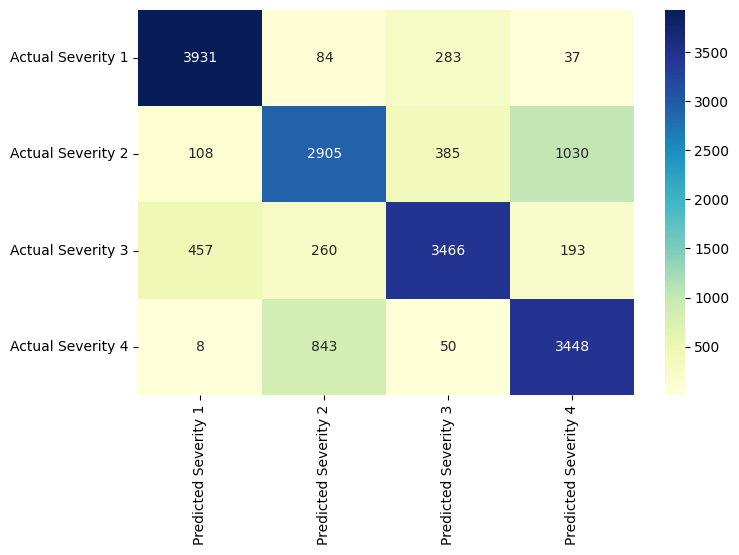

In [100]:
sample = X_test
y_test_sample = sample["Severity"]
X_test_sample = sample.drop("Severity", axis=1)

y_pred = rfc.predict(X_test_sample)

print(classification_report(y_test_sample, y_pred))

confmat = confusion_matrix(y_true=y_test_sample, y_pred=y_pred)

index = ["Actual Severity 1", "Actual Severity 2", "Actual Severity 3", "Actual Severity 4"]
columns = ["Predicted Severity 1", "Predicted Severity 2", "Predicted Severity 3", "Predicted Severity 4"]
conf_matrix = pd.DataFrame(data=confmat, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.show()